<a href="https://colab.research.google.com/github/sontranjvn/EDA_Optimising_NYC_Taxis_SONHTRAN/blob/main/LR_Delivery_Time_Prediction_SON_TH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [ ]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot

# Set the style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set(style="darkgrid")

# For better visualization
plt.rcParams['figure.figsize'] = (12, 8)


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [ ]:
# Importing the file porter_data_1.csv
df = pd.read_csv('C:/Users/SonTH-MSN\Documents/upgrad/30688323-a1ea-4809-83c4-91d8096236c8-Delivery-Starter/Delivery_Starter/porter_data_1.csv')

# Display basic information about the dataset
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check for data types and missing values
print("\nData types and non-null counts:")
print(df.info())

# Summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

<>:2: SyntaxWarning: invalid escape sequence '\D'
<>:2: SyntaxWarning: invalid escape sequence '\D'
C:\Users\SonTH-MSN\AppData\Local\Temp\ipykernel_7912\4107289833.py:2: SyntaxWarning: invalid escape sequence '\D'
  df = pd.read_csv('C:/Users/SonTH-MSN\Documents/upgrad/30688323-a1ea-4809-83c4-91d8096236c8-Delivery-Starter/Delivery_Starter/porter_data_1.csv')


Dataset Shape: (175777, 14)

First 5 rows of the dataset:
   market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1   

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [ ]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Verify the conversion
print("Data types after conversion:")
print(df[['created_at', 'actual_delivery_time']].dtypes)


Data types after conversion:
created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [ ]:
# Convert categorical features to category type
categorical_features = ['market_id', 'store_primary_category', 'order_protocol']
for feature in categorical_features:
    df[feature] = df[feature].astype('category')

# Verify the conversion
print("\nData types after conversion:")
print(df[categorical_features].dtypes)




Data types after conversion:
market_id                 category
store_primary_category    category
order_protocol            category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [ ]:
# Calculate time taken in minutes
df['time_taken'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Display the new column
print("Time taken (in minutes) statistics:")
print(df['time_taken'].describe())

# Check for any negative or extremely large values
print(f"\nNumber of orders with negative delivery times: {sum(df['time_taken'] < 0)}")
print(f"Number of orders with delivery times > 180 minutes: {sum(df['time_taken'] > 180)}")


Time taken (in minutes) statistics:
count    175777.000000
mean         46.203013
std           9.327424
min          32.000000
25%          39.000000
50%          45.000000
75%          52.000000
max         110.000000
Name: time_taken, dtype: float64

Number of orders with negative delivery times: 0
Number of orders with delivery times > 180 minutes: 0


##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [ ]:
# Extract the hour and day of week from the 'created_at' timestamp
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Convert isWeekend to category
df['isWeekend'] = df['isWeekend'].astype('category')

# Display statistics about the new features
print("\nHour distribution:")
print(df['hour'].value_counts().sort_index())
print("\nDay of week distribution (0=Monday, 6=Sunday):")
print(df['day_of_week'].value_counts().sort_index())
print("\nWeekend orders percentage:")
print(df['isWeekend'].value_counts(normalize=True) * 100)



Hour distribution:
hour
0     11464
1     25722
2     32896
3     23693
4     13248
5      6078
6      1223
7         9
8         2
14       38
15      502
16     1936
17     3058
18     4514
19    12083
20    13883
21    10219
22     7875
23     7334
Name: count, dtype: int64

Day of week distribution (0=Monday, 6=Sunday):
day_of_week
0    24202
1    21483
2    21753
3    22584
4    25004
5    30858
6    29893
Name: count, dtype: int64

Weekend orders percentage:
isWeekend
0    65.438595
1    34.561405
Name: proportion, dtype: float64


In [ ]:
# Drop unnecessary columns
df_processed = df.drop(['created_at', 'actual_delivery_time'], axis=1)

# Verify the columns in the processed dataframe
print("\nColumns in the processed dataframe:")
print(df_processed.columns.tolist())



Columns in the processed dataframe:
['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'time_taken', 'hour', 'day_of_week', 'isWeekend']


#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [ ]:
# Define target variable (y) and features (X)
target_column = 'time_taken'
y = df_processed[target_column]
X = df_processed.drop(target_column, axis=1)

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Display the shapes
print(f"Shape of features (X): {X.shape}")
print(f"Shape of target (y): {y.shape}")
print(f"Feature columns: {X.columns.tolist()}")

Shape of features (X): (175777, 95)
Shape of target (y): (175777,)
Feature columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour', 'day_of_week', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5', 'store_primary_category_6', 'store_primary_category_7', 'store_primary_category_8', 'store_primary_category_9', 'store_primary_category_10', 'store_primary_category_11', 'store_primary_category_12', 'store_primary_category_13', 'store_primary_category_14', 'store_primary_category_15', 'store_primary_category_16', 'store_primary_category_17', 'store_primary_category_18', 'store_primary_category_19', 'store_primary_category_20', 'store_primary_category_21', 'store_primary_category_22', 'store

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Display the shapes of training and testing sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (140621, 95), y_train shape: (140621,)
X_test shape: (35156, 95), y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['category', 'bool']).columns.tolist()

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Categorical columns: ['market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5', 'store_primary_category_6', 'store_primary_category_7', 'store_primary_category_8', 'store_primary_category_9', 'store_primary_category_10', 'store_primary_category_11', 'store_primary_category_12', 'store_primary_category_13', 'store_primary_category_14', 'store_primary_category_15', 'store_primary_category_16', 'store_primary_category_17', 'store_primary_category_18', 'store_primary_category_19', 'store_primary_category_20', 'store_primary_category_21', 'store_primary_category_22', 'store_primary_category_23', 'store_primary_category_24', 'store_primary

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

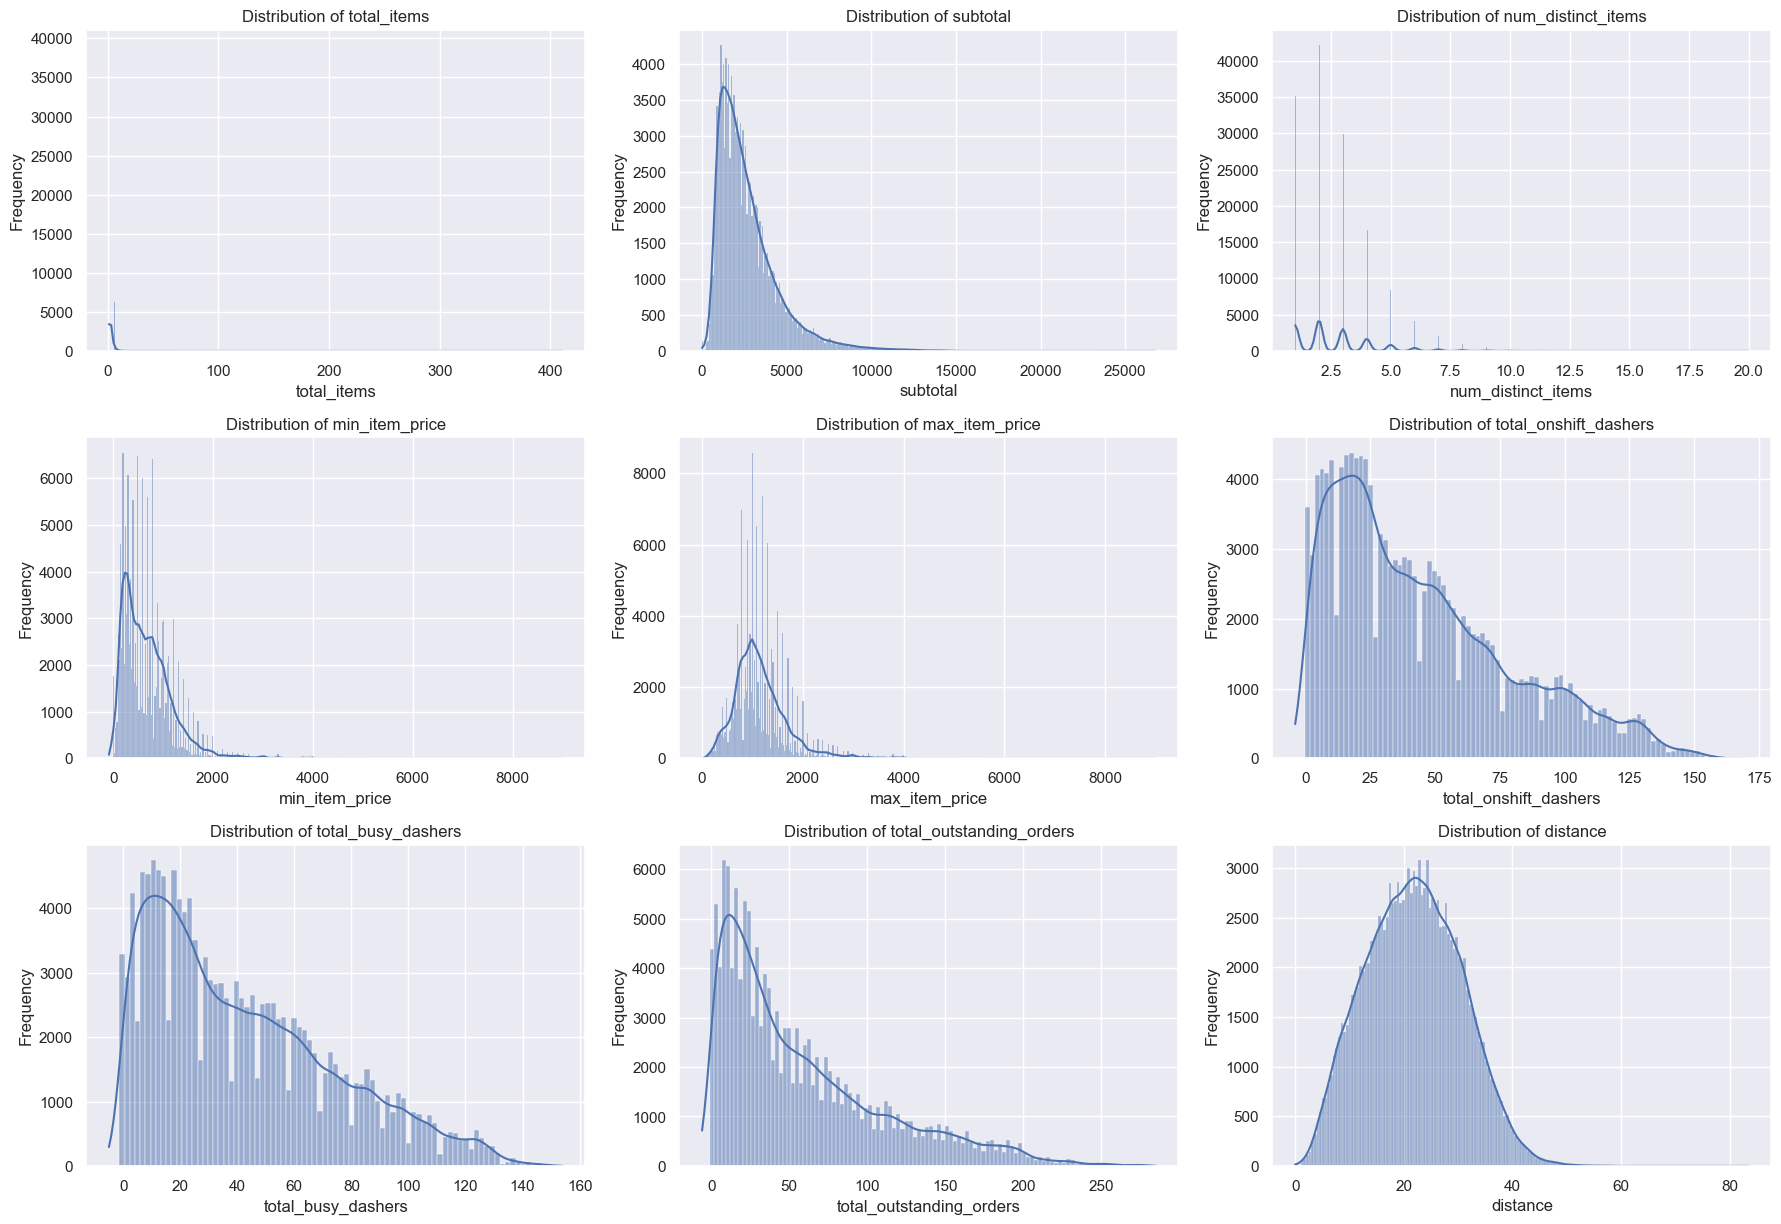

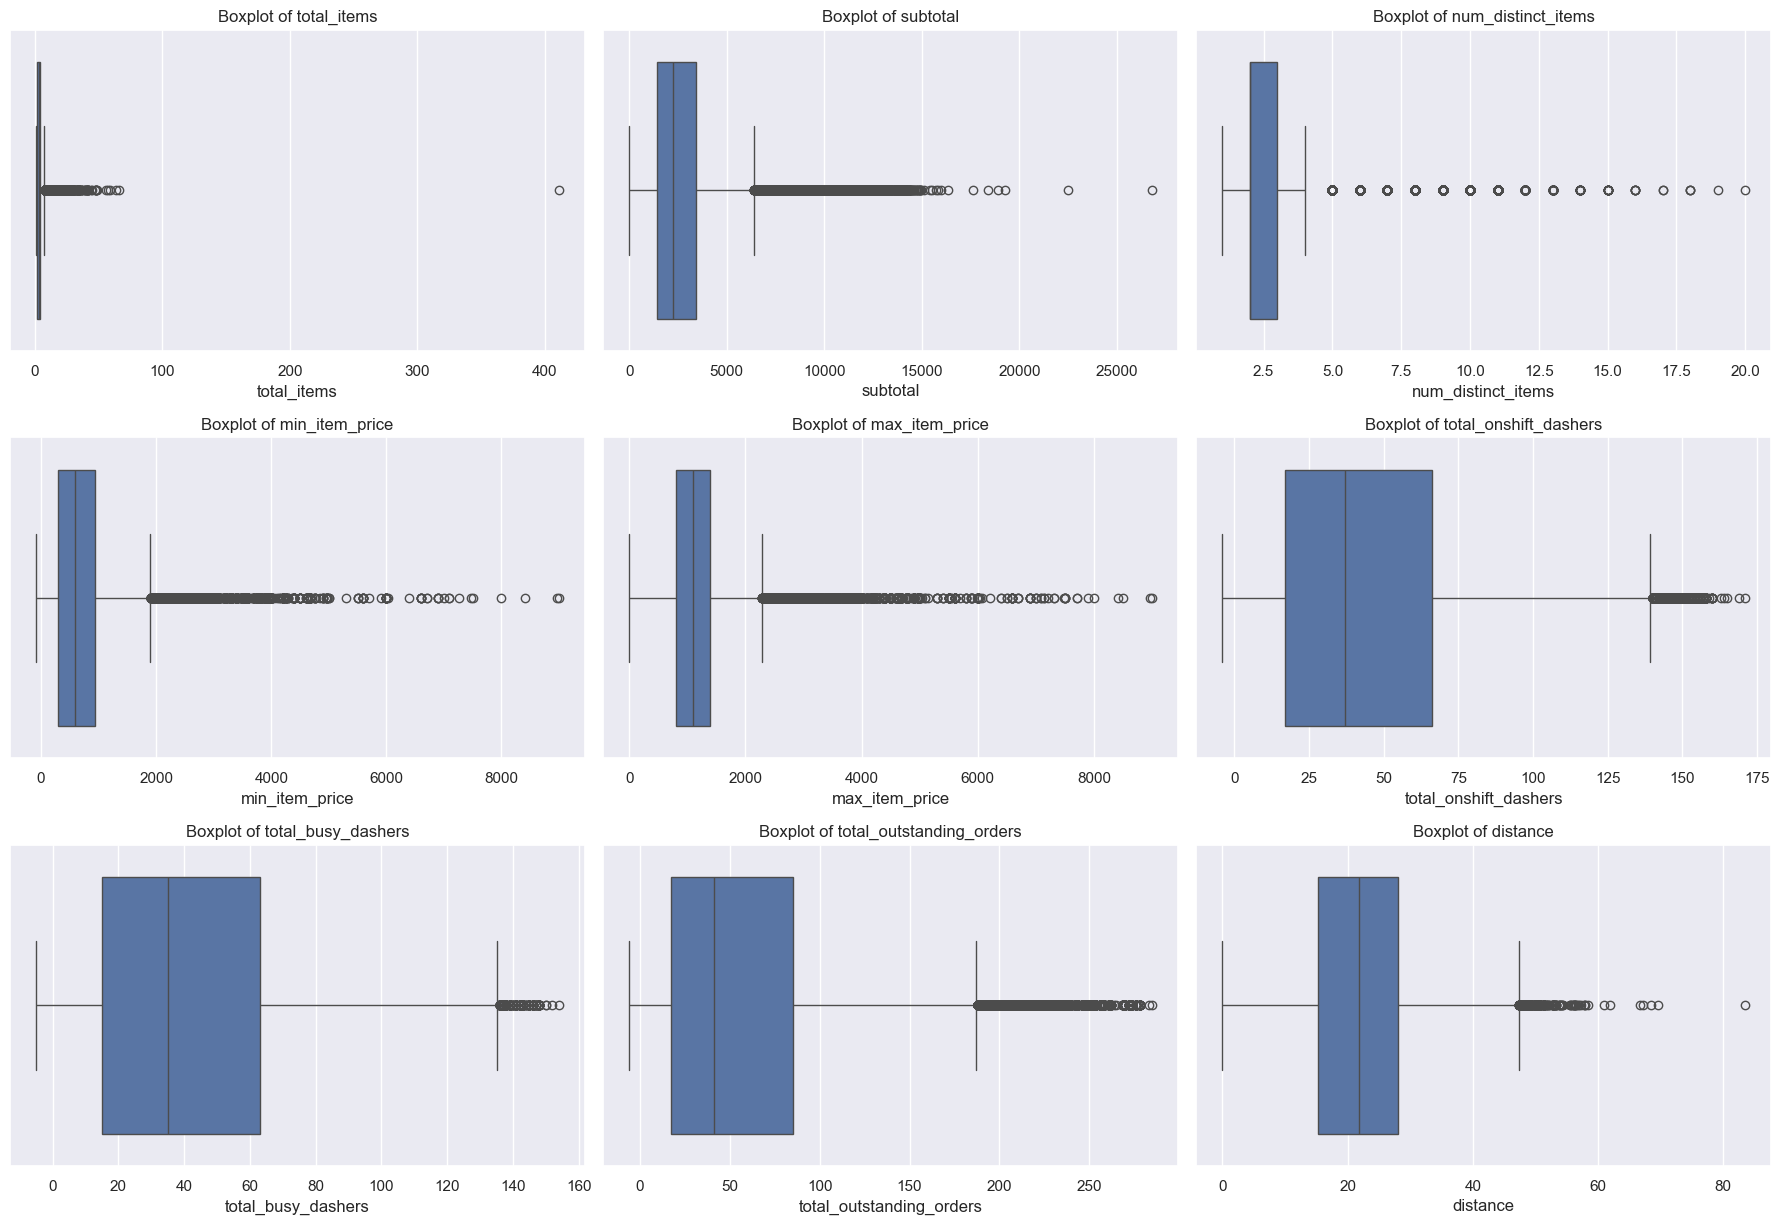

In [ ]:
# Plot distributions for all numerical columns
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i < len(axes):
        sns.histplot(X_train[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot boxplots for numerical columns to identify potential outliers
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(18, 16))
axes = axes.flatten()

for i, col in enumerate(numerical_cols):
    if i < len(axes):
        sns.boxplot(x=X_train[col], ax=axes[i])
        axes[i].set_title(f'Boxplot of {col}')
        axes[i].set_xlabel(col)

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [ ]:
# Distribution of categorical columns
dummy_cols = [col for col in X_train.columns if col not in numerical_cols]

fig, axes = plt.subplots(nrows=len(dummy_cols), ncols=1, figsize=(15, 5*len(dummy_cols)))

if len(dummy_cols) == 1:
    axes = [axes]

for i, col in enumerate(dummy_cols):
    sns.countplot(x=X_train[col], ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')

    # Add percentages on top of the bars
    total = len(X_train[col])
    for p in axes[i].patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        axes[i].annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

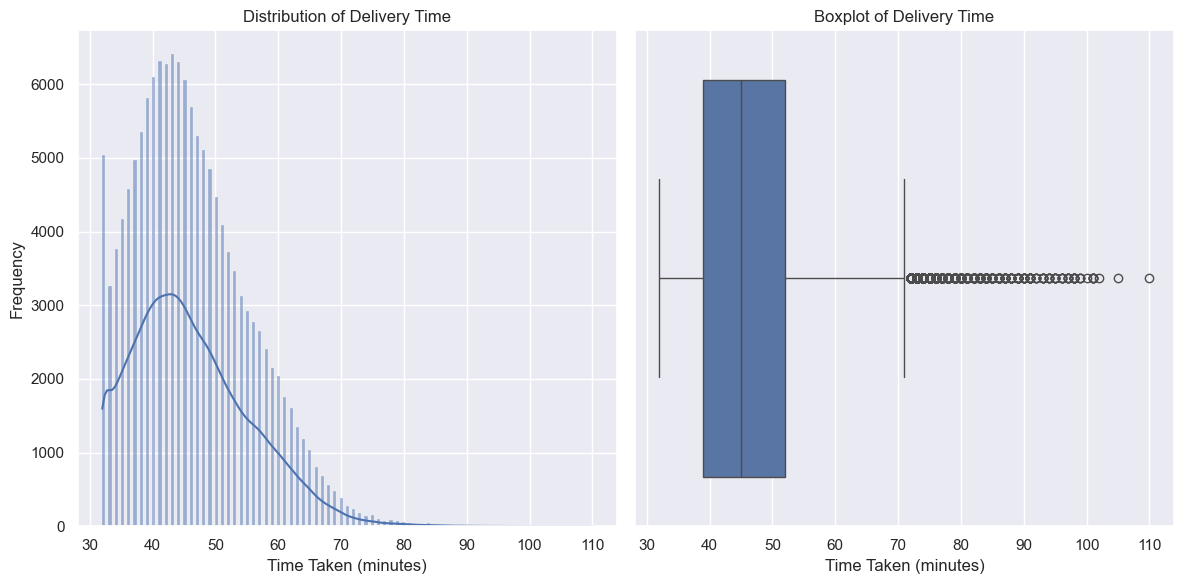

<Figure size 1000x800 with 0 Axes>

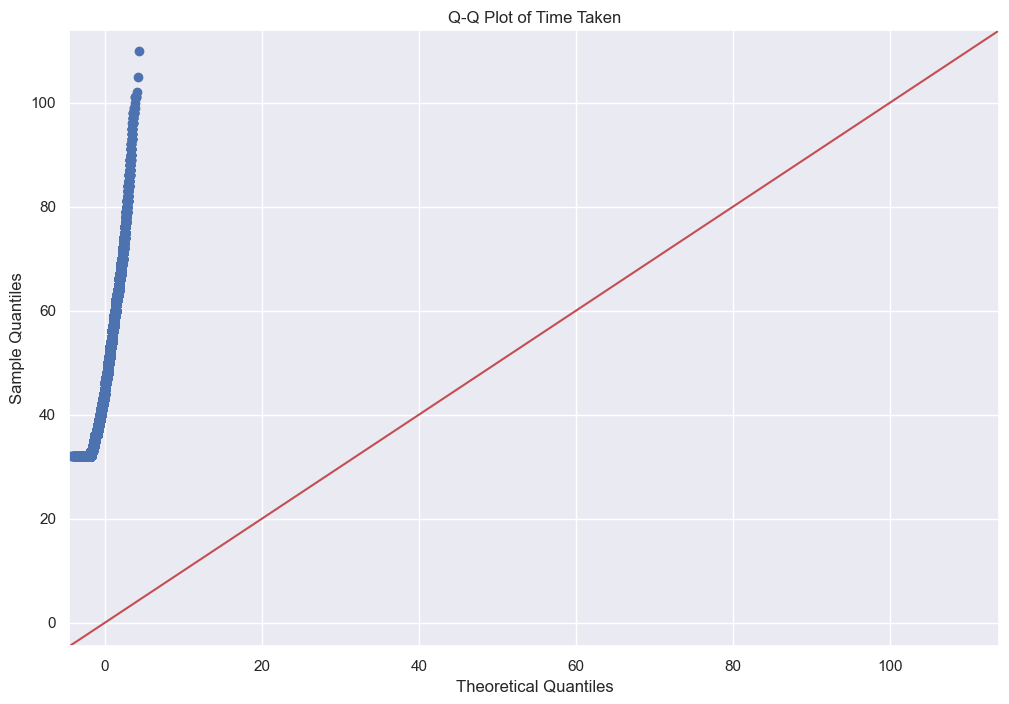

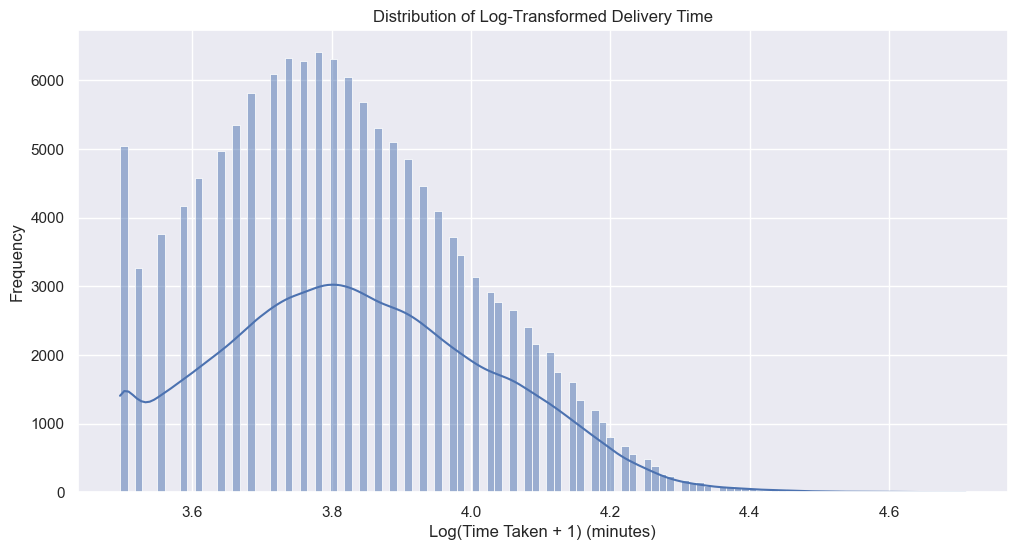

In [ ]:
# Distribution of time_taken
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True)
plt.title('Distribution of Delivery Time')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=y_train)
plt.title('Boxplot of Delivery Time')
plt.xlabel('Time Taken (minutes)')

plt.tight_layout()
plt.show()

# Q-Q plot to check for normality
plt.figure(figsize=(10, 8))
sm.qqplot(y_train, line='45')
plt.title('Q-Q Plot of Time Taken')
plt.show()

# Log transformation to check if it improves normality
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(y_train), kde=True)
plt.title('Distribution of Log-Transformed Delivery Time')
plt.xlabel('Log(Time Taken + 1) (minutes)')
plt.ylabel('Frequency')
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

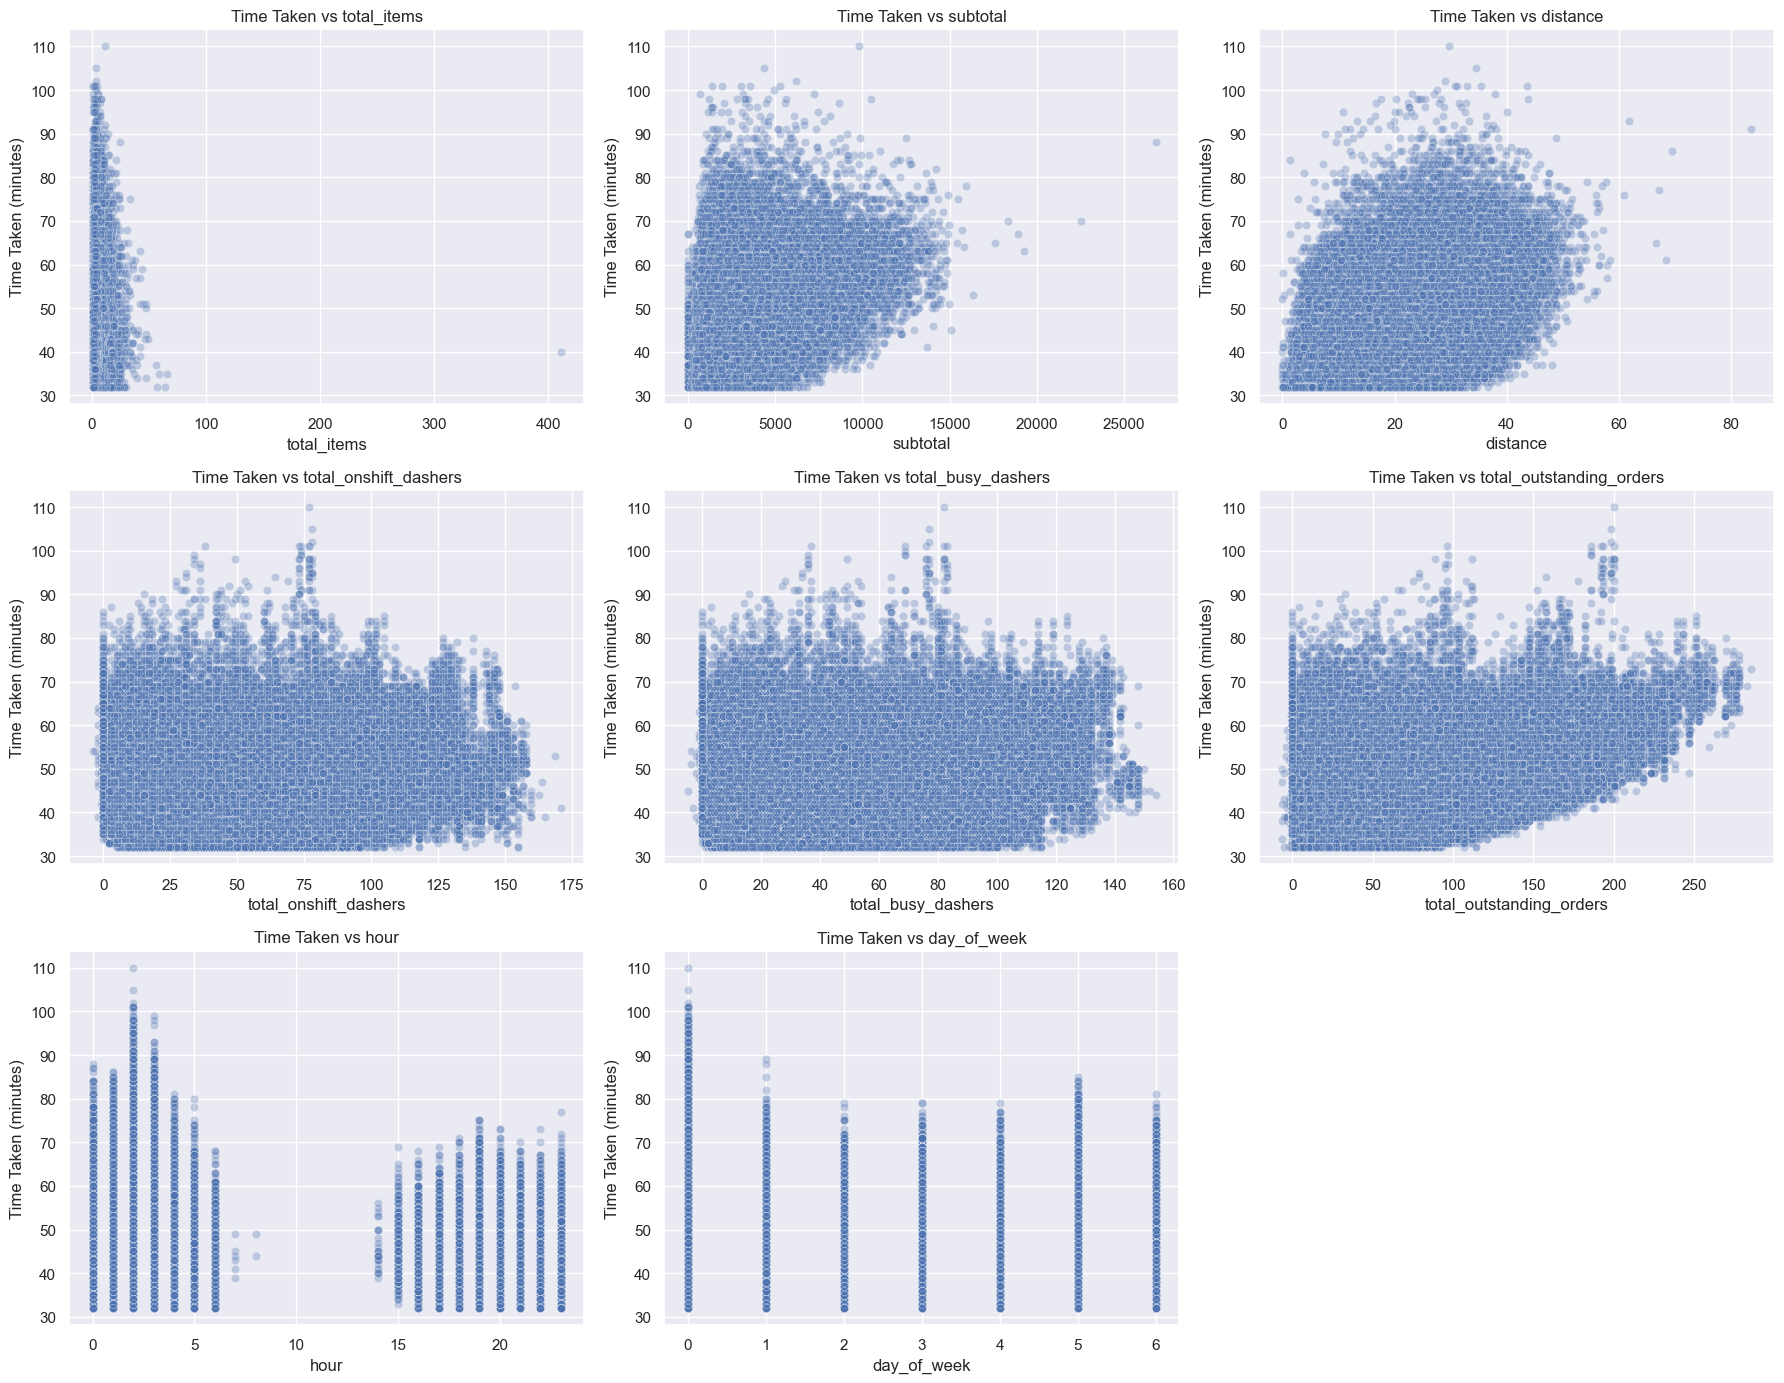

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

# Select important numerical features for visualization
important_features = ['total_items', 'subtotal', 'distance',
                     'total_onshift_dashers', 'total_busy_dashers',
                     'total_outstanding_orders', 'hour', 'day_of_week']

for i, feature in enumerate(important_features[:min(len(important_features), len(axes))]):
    if feature in X_train.columns:
        sns.scatterplot(x=X_train[feature], y=y_train, alpha=0.3, ax=axes[i])
        axes[i].set_title(f'Time Taken vs {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Time Taken (minutes)')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

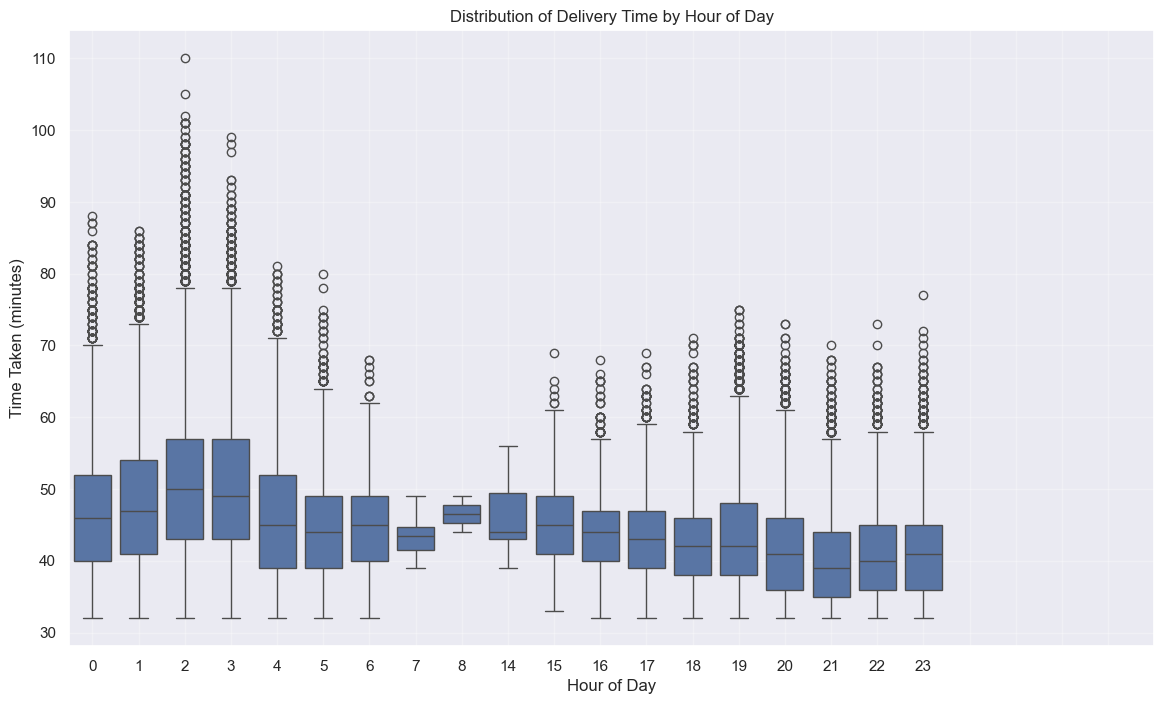

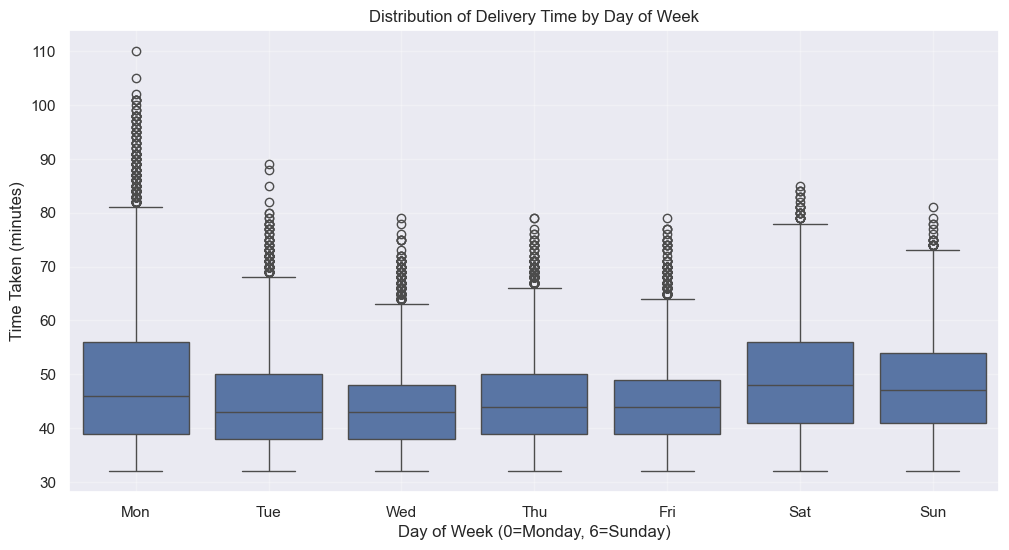

In [ ]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(14, 8))
sns.boxplot(x='hour', y=y_train, data=pd.concat([X_train['hour'], y_train], axis=1))
plt.title('Distribution of Delivery Time by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Time Taken (minutes)')
plt.xticks(range(24))
plt.grid(True, alpha=0.3)
plt.show()

# Show the distribution of time_taken for different days of week
plt.figure(figsize=(12, 6))
sns.boxplot(x='day_of_week', y=y_train, data=pd.concat([X_train['day_of_week'], y_train], axis=1))
plt.title('Distribution of Delivery Time by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Time Taken (minutes)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, alpha=0.3)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

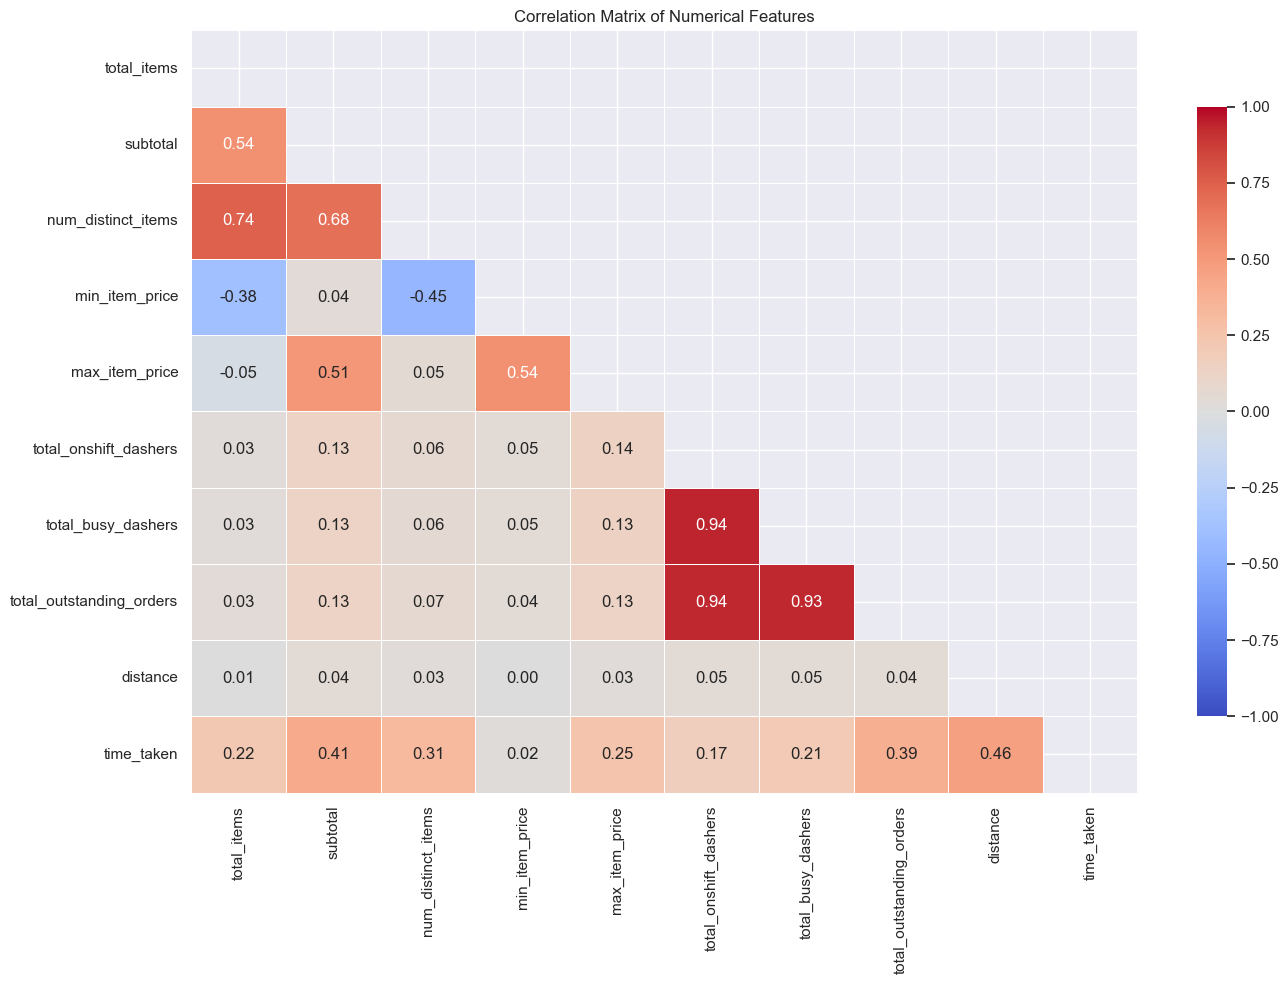

Correlations with 'time_taken':
distance                    0.461026
subtotal                    0.413392
total_outstanding_orders    0.385028
num_distinct_items          0.312510
max_item_price              0.254650
total_items                 0.220804
total_busy_dashers          0.206514
total_onshift_dashers       0.171828
min_item_price              0.021151
Name: time_taken, dtype: float64


In [ ]:
# Plot the heatmap of the correlation matrix
# Create a dataset with the target variable included
correlation_data = pd.concat([X_train[numerical_cols], y_train], axis=1)

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            mask=mask, vmin=-1, vmax=1, linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Sort correlations with the target variable
target_correlations = correlation_matrix['time_taken'].drop('time_taken').sort_values(ascending=False)
print("Correlations with 'time_taken':")
print(target_correlations)

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [ ]:
# Drop 3-5 weakly correlated columns from training dataset
# First, identify weak correlations (absolute correlation < 0.05)
weak_correlations = target_correlations[abs(target_correlations) < 0.05].index.tolist()
print(f"Features with weak correlations: {weak_correlations}")

# Remove weak features from the dataset
X_train_filtered = X_train.drop(columns=weak_correlations)
X_test_filtered = X_test.drop(columns=weak_correlations)

print(f"Shape after dropping weak correlations: {X_train_filtered.shape}")
print(f"Remaining columns: {X_train_filtered.columns.tolist()}")

Features with weak correlations: ['min_item_price']
Shape after dropping weak correlations: (140621, 94)
Remaining columns: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour', 'day_of_week', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5', 'store_primary_category_6', 'store_primary_category_7', 'store_primary_category_8', 'store_primary_category_9', 'store_primary_category_10', 'store_primary_category_11', 'store_primary_category_12', 'store_primary_category_13', 'store_primary_category_14', 'store_primary_category_15', 'store_primary_category_16', 'store_primary_category_17', 'store_primary_category_18', 'store_primary_category_19', 'store_primary_category_20', 'store_primary_category_21', 'store_primar

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

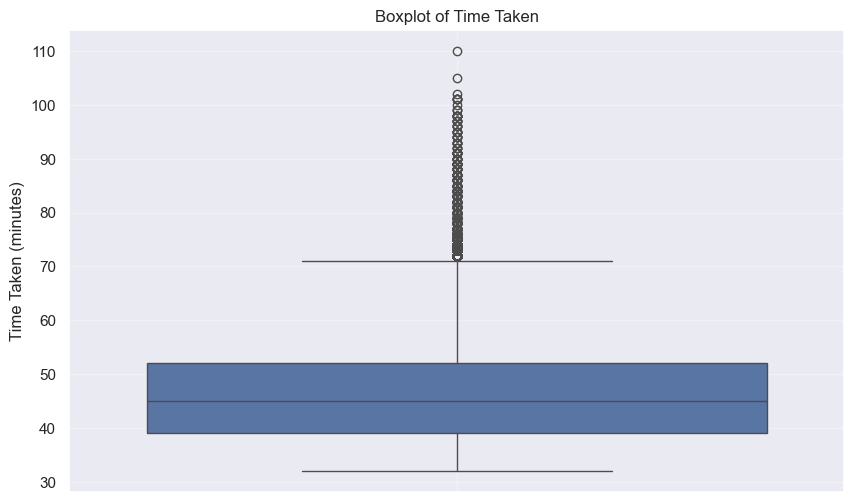

Target variable outlier boundaries:
Lower bound: 19.50 minutes
Upper bound: 71.50 minutes
Number of target outliers below lower bound: 0
Number of target outliers above upper bound: 1379
Percentage of outliers: 0.98%
Available numerical columns for boxplots: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


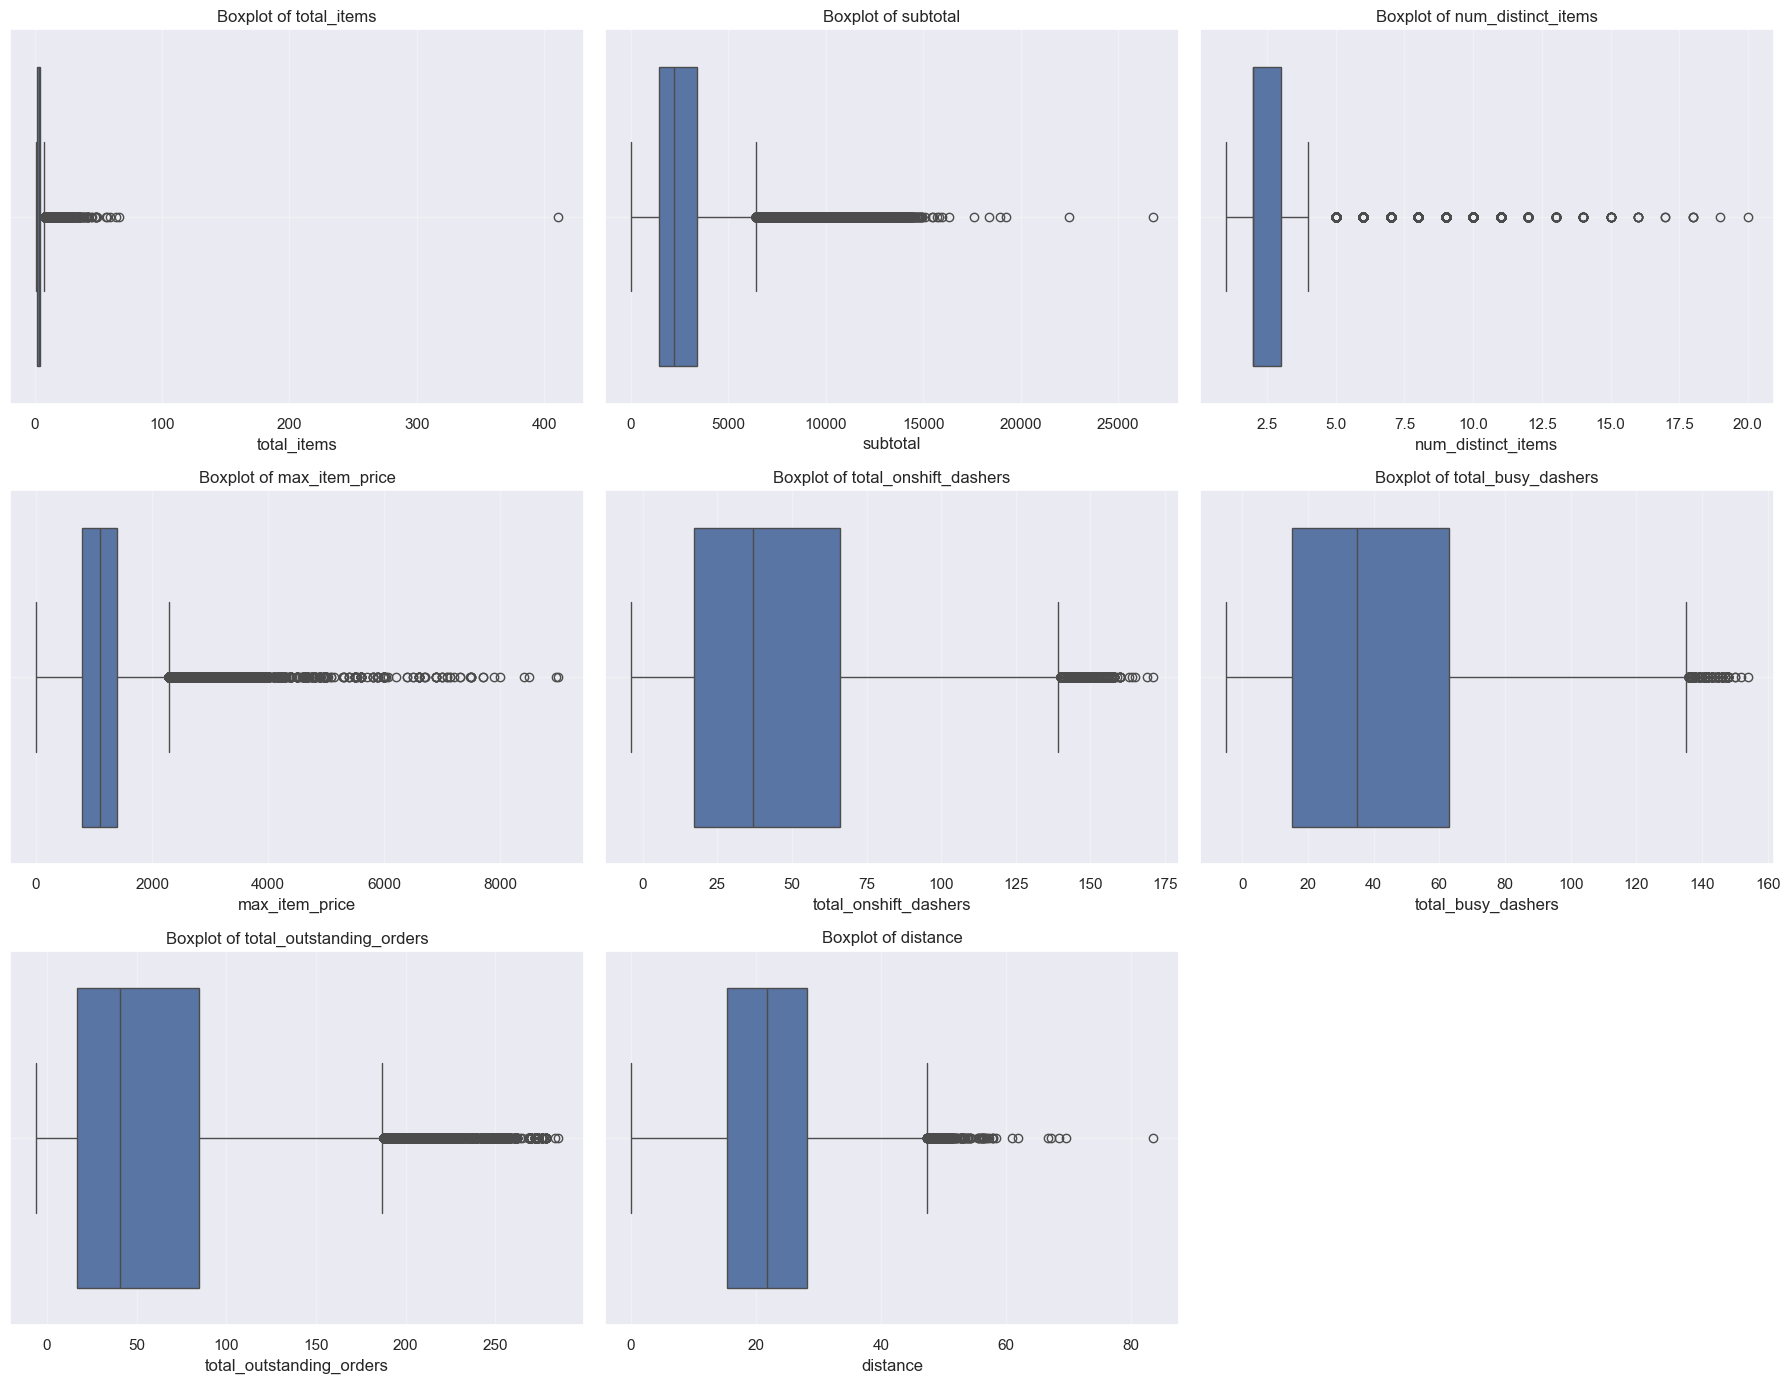

In [ ]:
# Boxplot for time_taken
plt.figure(figsize=(10, 6))
sns.boxplot(y=y_train)
plt.title('Boxplot of Time Taken')
plt.ylabel('Time Taken (minutes)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate outlier boundaries for the target variable
Q1_target = y_train.quantile(0.25)
Q3_target = y_train.quantile(0.75)
IQR_target = Q3_target - Q1_target
lower_bound = Q1_target - 1.5 * IQR_target
upper_bound = Q3_target + 1.5 * IQR_target

print(f"Target variable outlier boundaries:")
print(f"Lower bound: {lower_bound:.2f} minutes")
print(f"Upper bound: {upper_bound:.2f} minutes")
print(f"Number of target outliers below lower bound: {sum(y_train < lower_bound)}")
print(f"Number of target outliers above upper bound: {sum(y_train > upper_bound)}")
print(f"Percentage of outliers: {100 * (sum(y_train < lower_bound) + sum(y_train > upper_bound)) / len(y_train):.2f}%")

# Get the columns that actually exist in X_train_filtered
available_numerical_cols = [col for col in numerical_cols if col in X_train_filtered.columns]
print(f"Available numerical columns for boxplots: {available_numerical_cols}")

# Boxplots for important numerical features (only those that exist in X_train_filtered)
plt.figure(figsize=(18, 14))
for i, col in enumerate(available_numerical_cols[:min(9, len(available_numerical_cols))]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x=X_train_filtered[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.grid(True, alpha=0.3)

# Remove empty subplots if any
for j in range(i + 1, 9):
    plt.subplot(3, 3, j+1)
    plt.axis('off')

plt.tight_layout()
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

Available numerical columns in training set: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']
Available numerical columns in test set: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance']


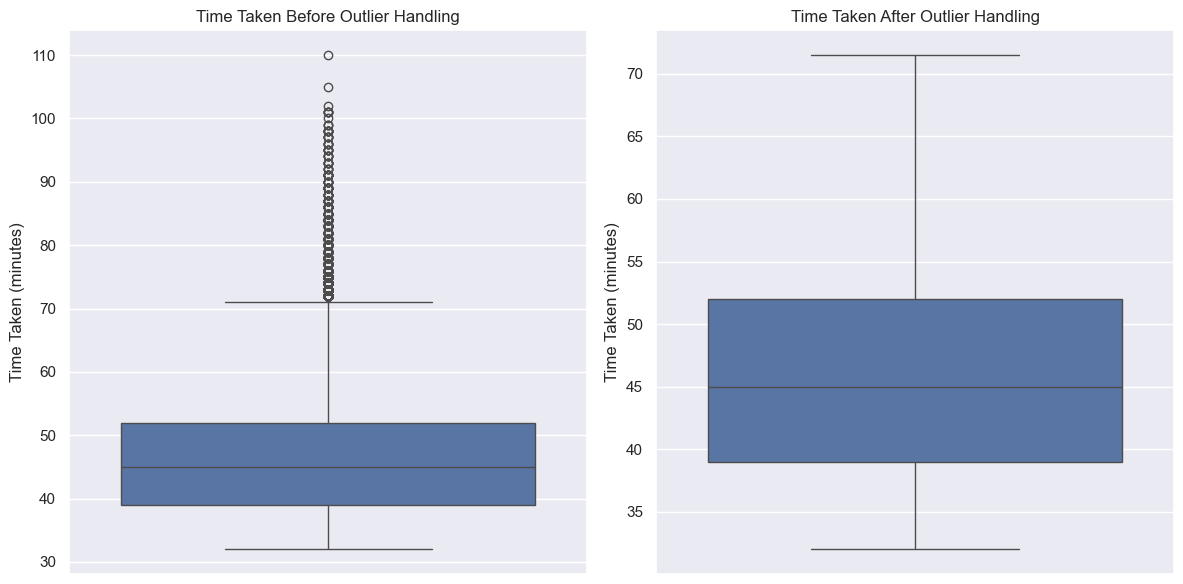

Original target range: [32.00, 110.00]
Cleaned target range: [32.00, 71.50]

Number of columns in X_train_filtered: 94
Number of columns in X_train_cleaned: 94


In [ ]:
# Handle outliers
def cap_outliers(df, columns):
    """Cap outliers at 1.5 IQR, but only for columns that exist in the DataFrame"""
    df_capped = df.copy()
    # Filter to only include columns that exist in the dataframe
    existing_columns = [col for col in columns if col in df.columns]

    for col in existing_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Cap the outliers
        df_capped[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df_capped[col] = np.where(df[col] > upper_bound, upper_bound, df_capped[col])

    return df_capped

# Check which numerical columns actually exist in X_train_filtered and X_test_filtered
available_train_cols = [col for col in numerical_cols if col in X_train_filtered.columns]
available_test_cols = [col for col in numerical_cols if col in X_test_filtered.columns]

print(f"Available numerical columns in training set: {available_train_cols}")
print(f"Available numerical columns in test set: {available_test_cols}")

# Apply outlier capping to numerical features that exist
X_train_cleaned = cap_outliers(X_train_filtered, available_train_cols)
X_test_cleaned = cap_outliers(X_test_filtered, available_test_cols)

# Handle outliers in the target variable
y_train_cleaned = y_train.copy()
Q1 = y_train.quantile(0.25)
Q3 = y_train.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap the outliers in the target
y_train_cleaned = np.where(y_train < lower_bound, lower_bound, y_train)
y_train_cleaned = np.where(y_train > upper_bound, upper_bound, y_train_cleaned)
y_train_cleaned = pd.Series(y_train_cleaned, index=y_train.index)

# Verify the impact of outlier capping
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=y_train)
plt.title('Time Taken Before Outlier Handling')
plt.ylabel('Time Taken (minutes)')

plt.subplot(1, 2, 2)
sns.boxplot(y=y_train_cleaned)
plt.title('Time Taken After Outlier Handling')
plt.ylabel('Time Taken (minutes)')

plt.tight_layout()
plt.show()

print(f"Original target range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"Cleaned target range: [{y_train_cleaned.min():.2f}, {y_train_cleaned.max():.2f}]")

# Check if there's a difference in the number of columns before and after cleaning
print(f"\nNumber of columns in X_train_filtered: {X_train_filtered.shape[1]}")
print(f"Number of columns in X_train_cleaned: {X_train_cleaned.shape[1]}")

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [ ]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols_test = X_test.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols_test = X_test.select_dtypes(include=['category', 'bool']).columns.tolist()

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

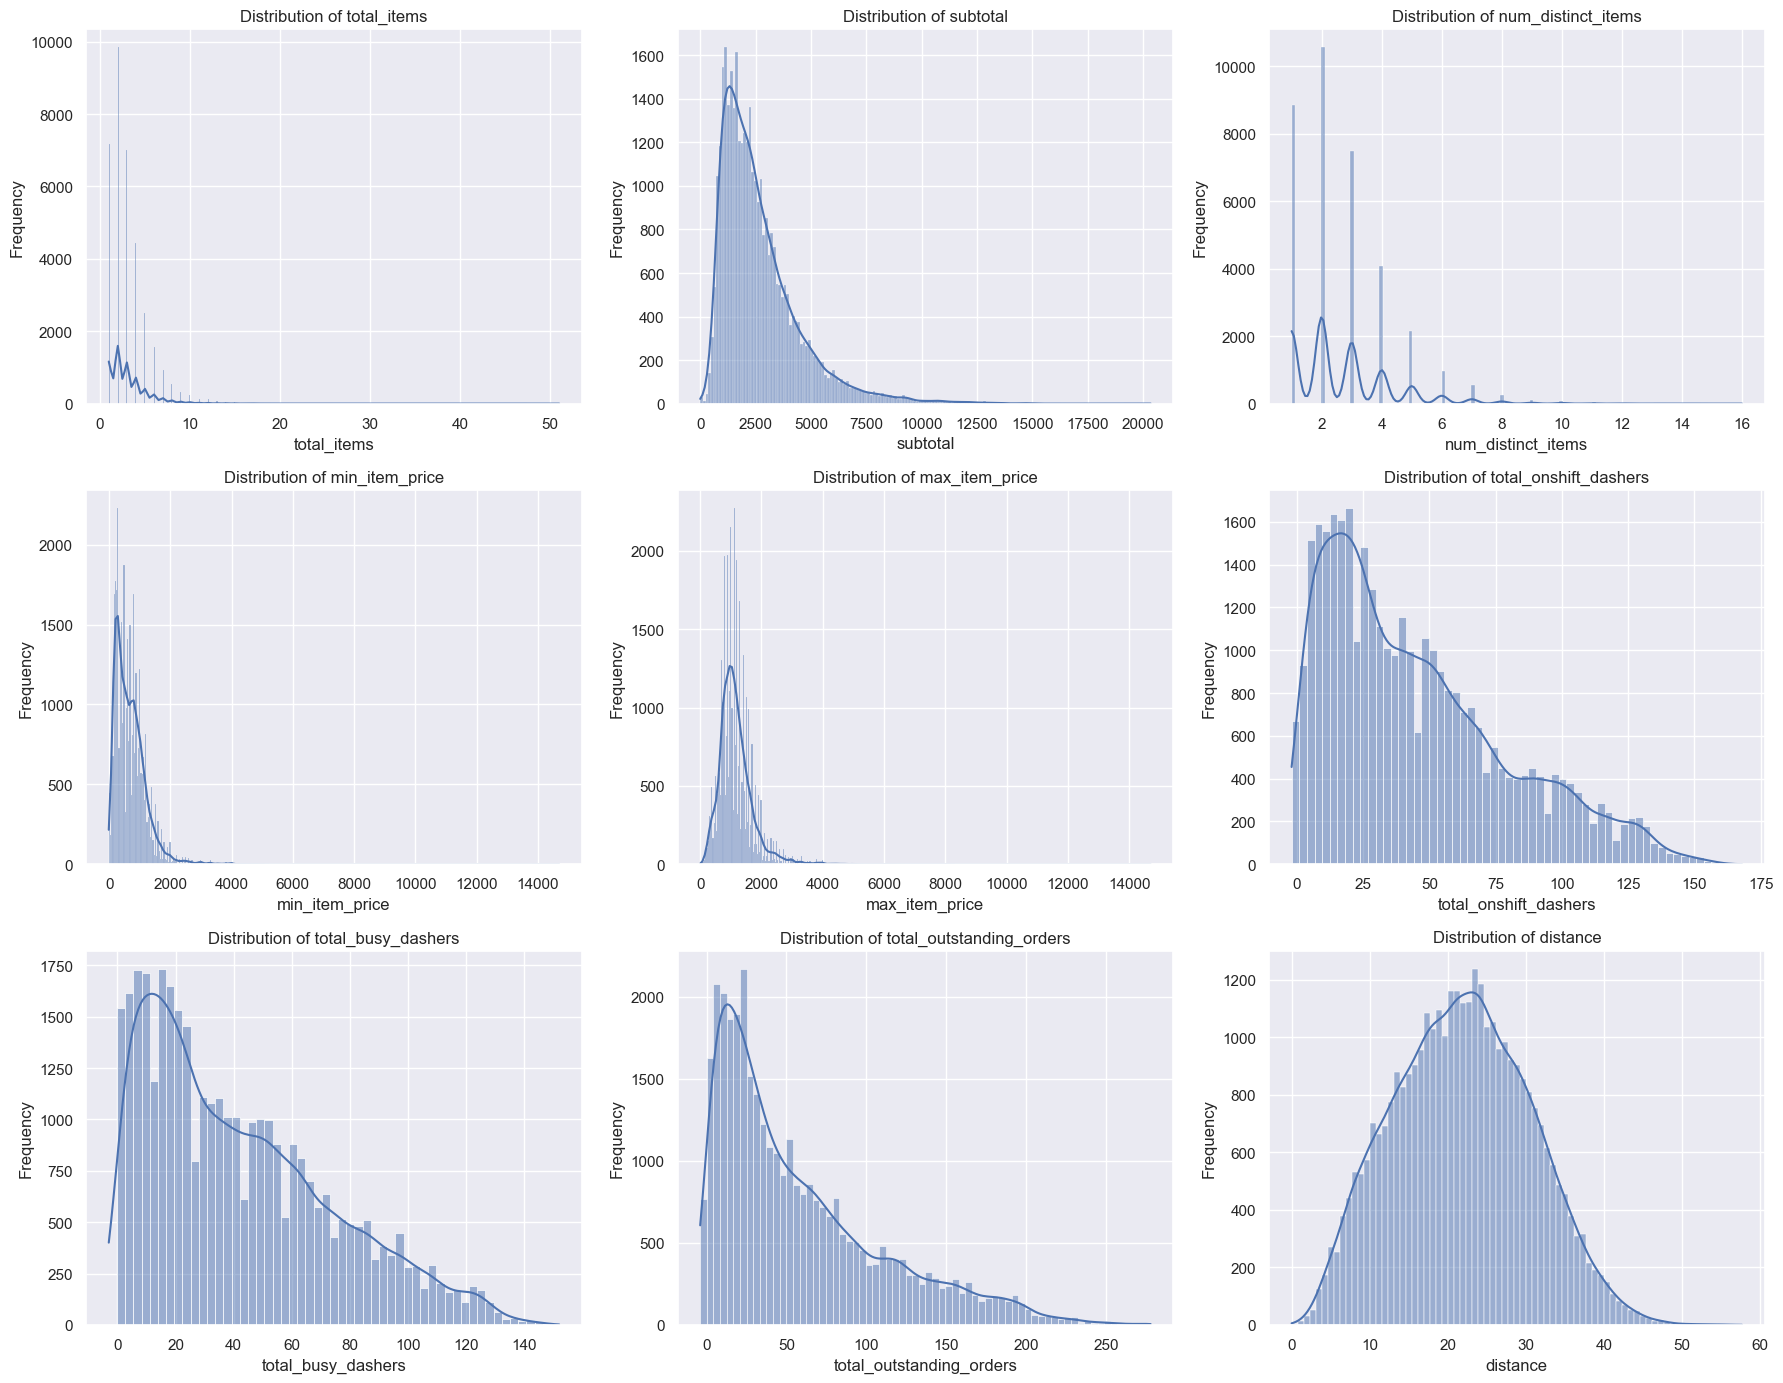

In [ ]:
# Plot distributions for all numerical columns
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 14))
axes = axes.flatten()

for i, col in enumerate(numerical_cols_test[:min(9, len(numerical_cols_test))]):
    sns.histplot(X_test[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

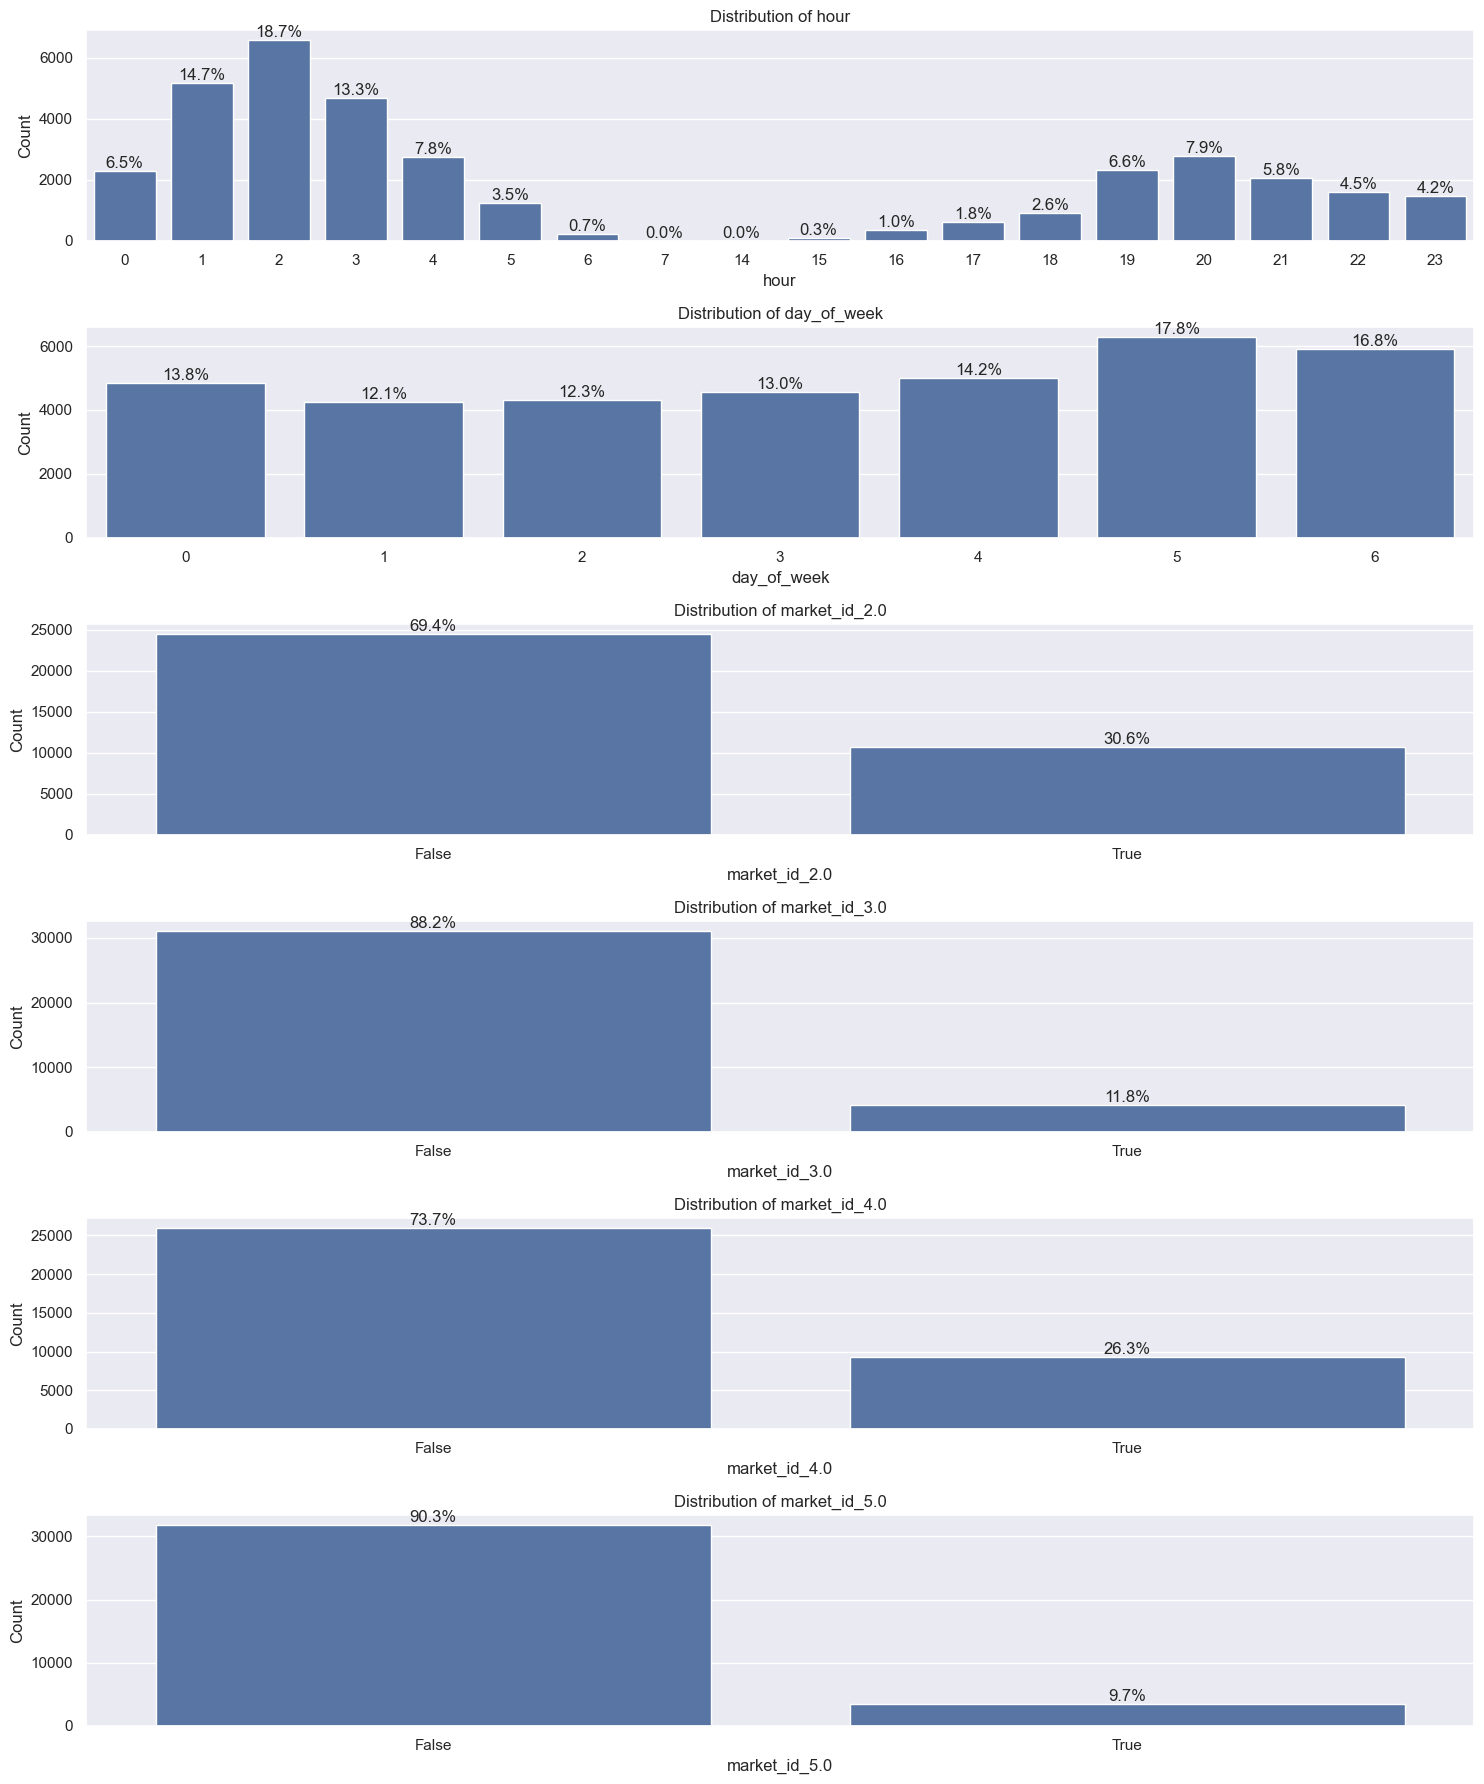

In [ ]:
# Distribution of categorical columns
dummy_cols_test = [col for col in X_test.columns if col not in numerical_cols_test]

if dummy_cols_test:
    fig, axes = plt.subplots(nrows=min(len(dummy_cols_test), 6), ncols=1, figsize=(15, 3*min(len(dummy_cols_test), 6)))

    if len(dummy_cols_test) == 1:
        axes = [axes]

    for i, col in enumerate(dummy_cols_test[:min(6, len(dummy_cols_test))]):
        sns.countplot(x=X_test[col], ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')

        # Add percentages on top of the bars
        total = len(X_test[col])
        for p in axes[i].patches:
            percentage = f'{100 * p.get_height() / total:.1f}%'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            axes[i].annotate(percentage, (x, y), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

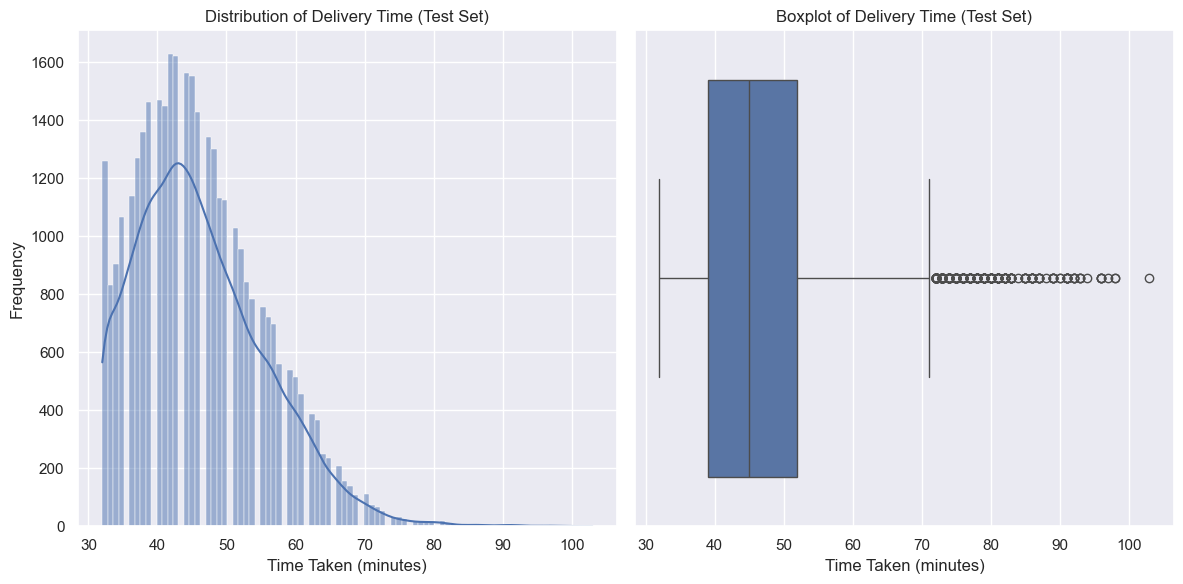

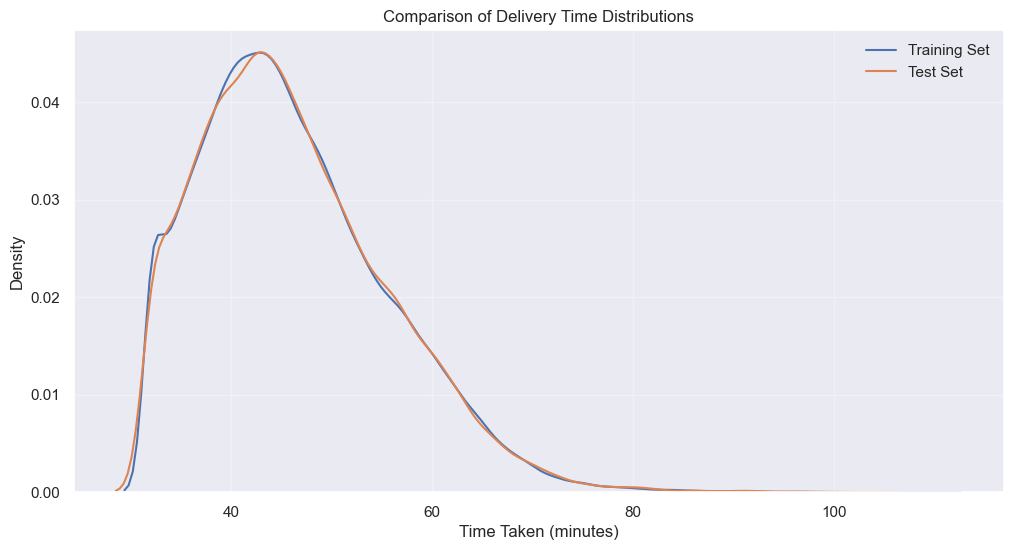

In [ ]:
# Distribution of time_taken
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(y_test, kde=True)
plt.title('Distribution of Delivery Time (Test Set)')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=y_test)
plt.title('Boxplot of Delivery Time (Test Set)')
plt.xlabel('Time Taken (minutes)')

plt.tight_layout()
plt.show()

# Compare training and test distributions
plt.figure(figsize=(12, 6))
sns.kdeplot(y_train, label='Training Set')
sns.kdeplot(y_test, label='Test Set')
plt.title('Comparison of Delivery Time Distributions')
plt.xlabel('Time Taken (minutes)')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

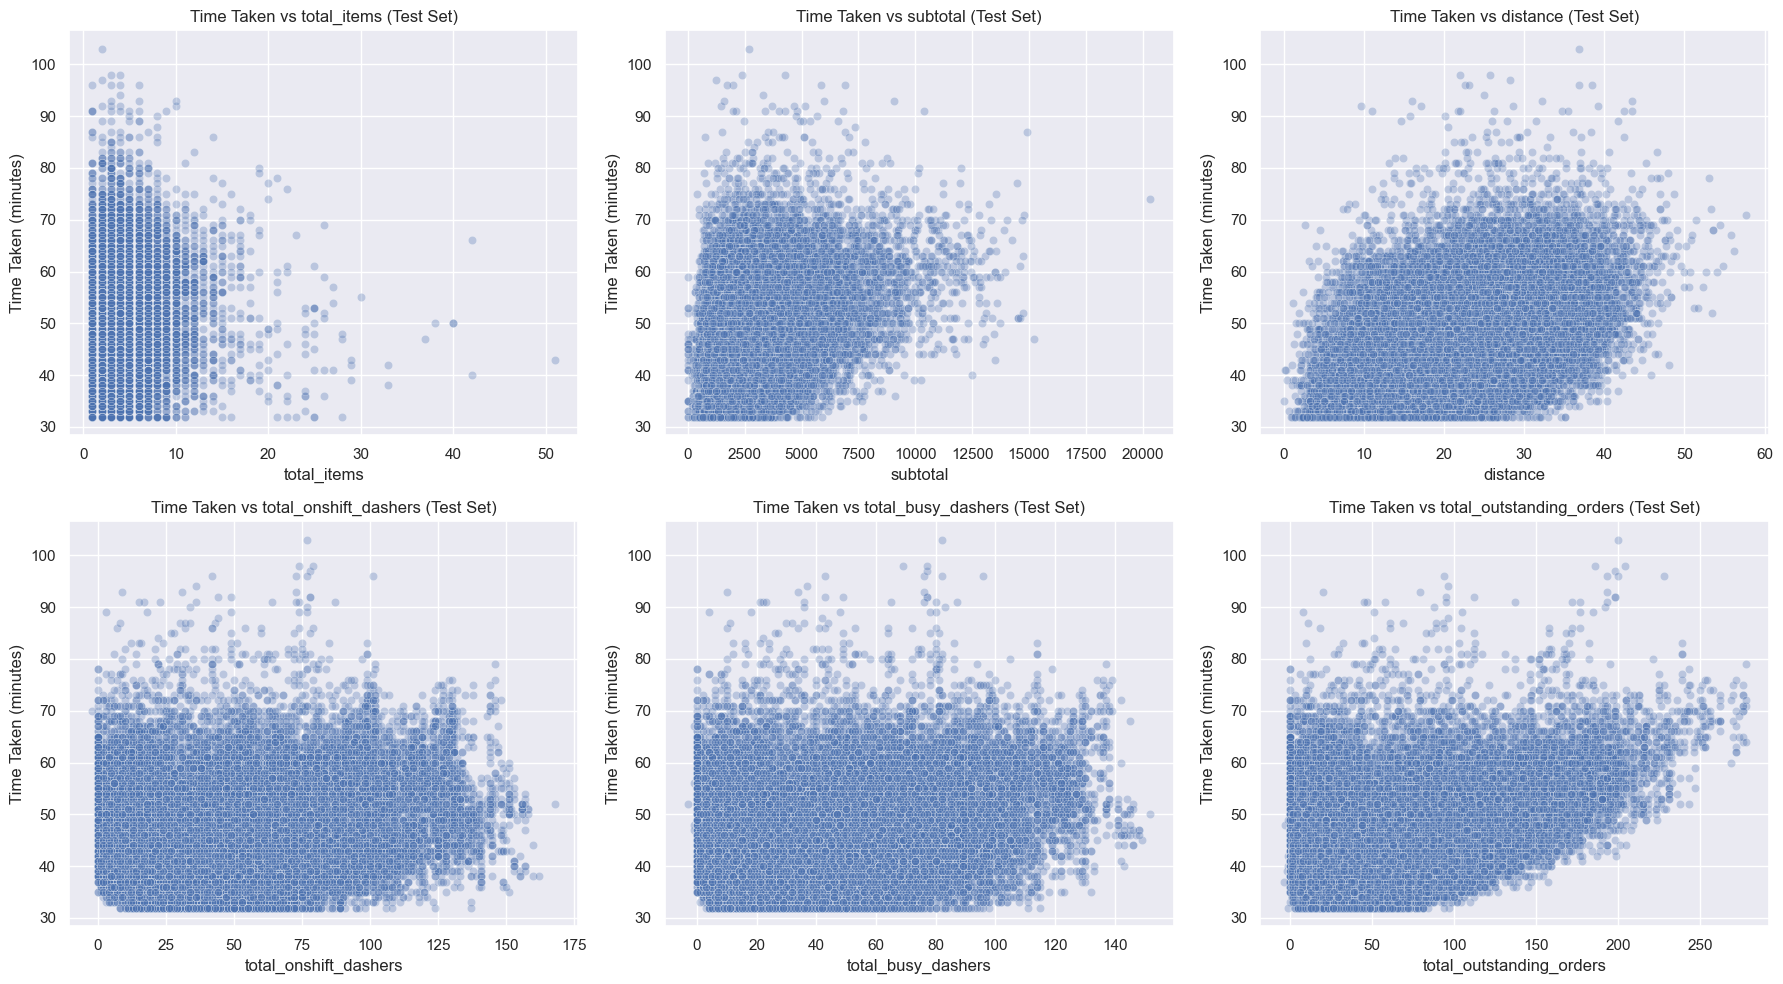

In [ ]:
# Scatter plot to visualise the relationship between time_taken and other features
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

# Select important numerical features for visualization
important_features = ['total_items', 'subtotal', 'distance',
                     'total_onshift_dashers', 'total_busy_dashers',
                     'total_outstanding_orders']

for i, feature in enumerate(important_features[:min(len(important_features), len(axes))]):
    if feature in X_test.columns:
        sns.scatterplot(x=X_test[feature], y=y_test, alpha=0.3, ax=axes[i])
        axes[i].set_title(f'Time Taken vs {feature} (Test Set)')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Time Taken (minutes)')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [ ]:
X_test_filtered = X_test.drop(columns=weak_correlations)
print(f"Test set shape after dropping weak correlations: {X_test_filtered.shape}")


Test set shape after dropping weak correlations: (35156, 94)


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [ ]:
# Apply scaling to the numerical columns
scaler = StandardScaler()

# Identify numerical columns in the cleaned datasets
numerical_cols_cleaned = X_train_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Scale the numerical columns
X_train_scaled = X_train_cleaned.copy()
X_test_scaled = X_test_cleaned.copy()

X_train_scaled[numerical_cols_cleaned] = scaler.fit_transform(X_train_cleaned[numerical_cols_cleaned])
X_test_scaled[numerical_cols_cleaned] = scaler.transform(X_test_cleaned[numerical_cols_cleaned])

# Verify the scaling
print("Before scaling (first 5 rows of first numerical column):")
print(X_train_cleaned[numerical_cols_cleaned[0]].head())
print("\nAfter scaling (first 5 rows of first numerical column):")
print(X_train_scaled[numerical_cols_cleaned[0]].head())

# Store the original (unscaled) dataset for later comparison
X_train_unscaled = X_train_cleaned.copy()
X_test_unscaled = X_test_cleaned.copy()

Before scaling (first 5 rows of first numerical column):
102712    1.0
94576     1.0
49784     4.0
37753     2.0
91728     1.0
Name: total_items, dtype: float64

After scaling (first 5 rows of first numerical column):
102712   -1.149075
94576    -1.149075
49784     0.559700
37753    -0.579483
91728    -1.149075
Name: total_items, dtype: float64


Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [ ]:
# Create/Initialise the model
lr_model = LinearRegression()

In [ ]:
# Train the model using the training data
lr_model.fit(X_train_scaled, y_train_cleaned)

LinearRegression()

In [ ]:
# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

Model Performance Metrics:
Training set - RMSE: 3.0276, MAE: 2.1107, R²: 0.8899
Test set - RMSE: 3.1454, MAE: 2.1455, R²: 0.8870


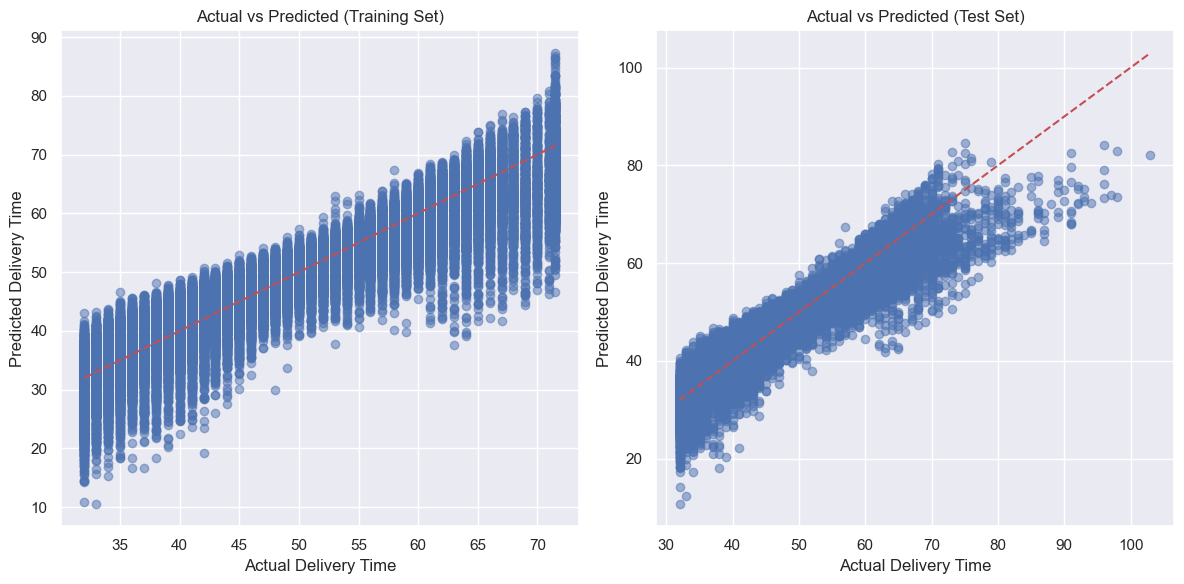

Statsmodels error: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Sử dụng phương pháp thay thế để hiển thị thông số mô hình:
Coefficient of Determination (R²): 0.8899
Mean Squared Error (MSE): 9.1664
Root Mean Squared Error (RMSE): 3.0276
Mean Absolute Error (MAE): 2.1107

Model Coefficients:
total_items: 0.284123
subtotal: 2.254427
num_distinct_items: 0.340749
max_item_price: 0.264480
total_onshift_dashers: -11.741343
total_busy_dashers: -4.096981
total_outstanding_orders: 17.755644
distance: 4.198336
hour: -0.204289
day_of_week: -0.155064
market_id_2.0: -4.777734
market_id_3.0: -4.049444
market_id_4.0: -4.089174
market_id_5.0: -3.387420
market_id_6.0: -2.785838
store_primary_category_1: 2.459987
store_primary_category_2: 0.440794
store_primary_category_3: 5.247095
store_primary_category_4: 0.347156
store_primary_category_5: 1.954594
store_primary_category_6: 0.431045
store_p

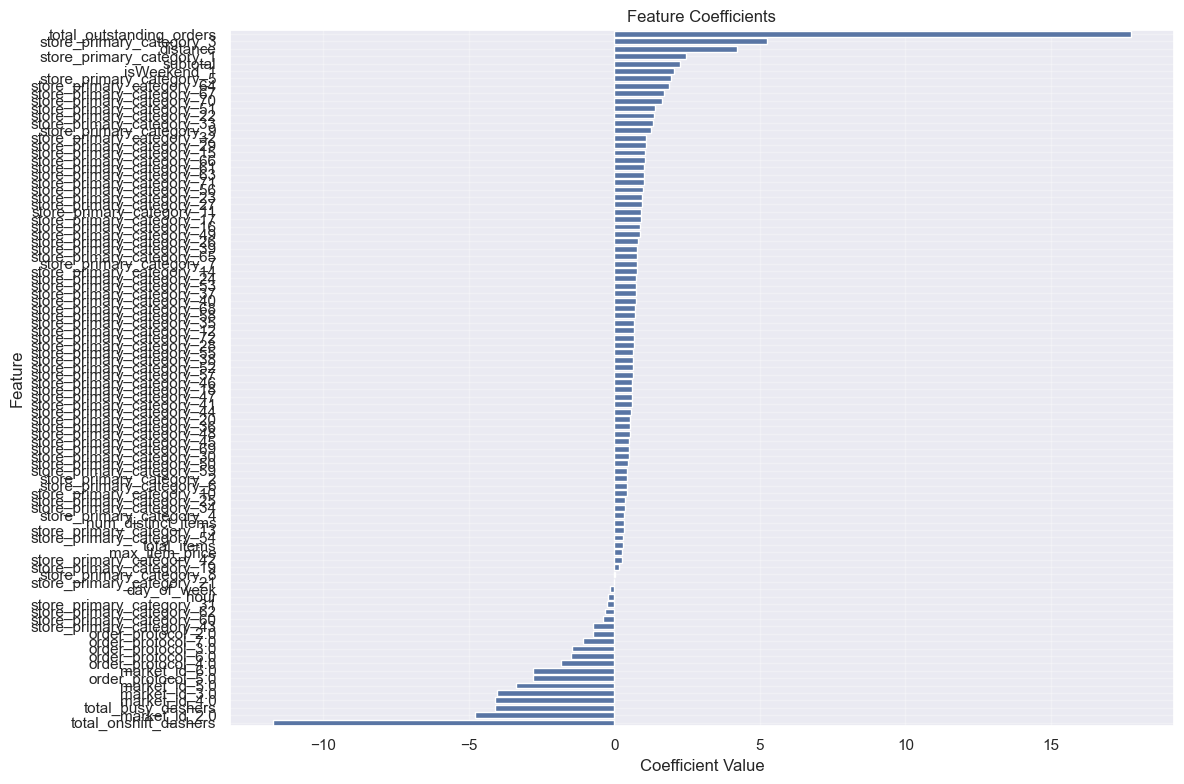

In [ ]:
# Find results for evaluation metrics
train_mse = mean_squared_error(y_train_cleaned, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_r2 = r2_score(y_train_cleaned, y_train_pred)
train_mae = mean_absolute_error(y_train_cleaned, y_train_pred)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Model Performance Metrics:")
print(f"Training set - RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"Test set - RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_cleaned, y_train_pred, alpha=0.5)
plt.plot([y_train_cleaned.min(), y_train_cleaned.max()], [y_train_cleaned.min(), y_train_cleaned.max()], 'r--')
plt.title('Actual vs Predicted (Training Set)')
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')

plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted (Test Set)')
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')

plt.tight_layout()
plt.show()

# Sử dụng statsmodels để có kết quả chi tiết hơn
# Chuyển đổi DataFrame thành numpy arrays để tránh lỗi 'object dtype'
X_train_sm_array = sm.add_constant(X_train_scaled.values)
y_train_cleaned_array = y_train_cleaned.values

try:
    # Thử với numpy arrays
    sm_model = sm.OLS(y_train_cleaned_array, X_train_sm_array).fit()
    print("\nStatsmodels Summary:")
    print(sm_model.summary())
except Exception as e:
    print(f"Statsmodels error: {e}")
    print("\nSử dụng phương pháp thay thế để hiển thị thông số mô hình:")
    # Hiển thị thông tin mô hình nếu statsmodels không hoạt động
    print(f"Coefficient of Determination (R²): {train_r2:.4f}")
    print(f"Mean Squared Error (MSE): {train_mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {train_rmse:.4f}")
    print(f"Mean Absolute Error (MAE): {train_mae:.4f}")

    # In các hệ số thủ công
    print("\nModel Coefficients:")
    for feature, coef in zip(X_train_scaled.columns, lr_model.coef_):
        print(f"{feature}: {coef:.6f}")
    print(f"Intercept: {lr_model.intercept_:.6f}")

# Extract coefficients
coefficients = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Coefficient': lr_model.coef_
})
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Visualize coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

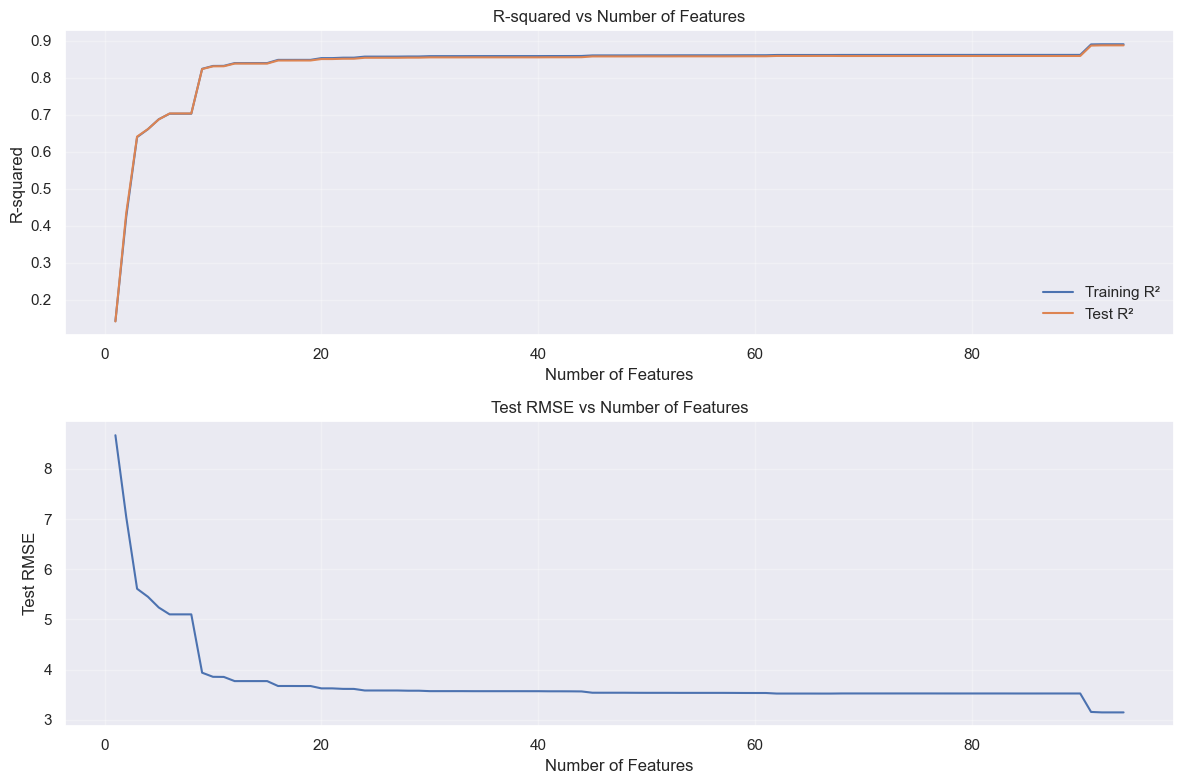

Optimal number of features based on test R²: 92
Optimal number of features based on test RMSE: 92

Selected features:
['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'hour', 'day_of_week', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0', 'store_primary_category_1', 'store_primary_category_2', 'store_primary_category_3', 'store_primary_category_4', 'store_primary_category_5', 'store_primary_category_6', 'store_primary_category_7', 'store_primary_category_9', 'store_primary_category_10', 'store_primary_category_11', 'store_primary_category_12', 'store_primary_category_13', 'store_primary_category_14', 'store_primary_category_15', 'store_primary_category_16', 'store_primary_category_17', 'store_primary_category_18', 'store_primary_category_19', 'store_primary_category_20', 'store_primary_category_22', 'store_primary_category_23', 'store_primary_cat

In [ ]:
# Loop through the number of features and test the model
results = []
feature_counts = range(1, len(X_train_scaled.columns) + 1)

for n_features in feature_counts:
    # Create and fit RFE model
    rfe = RFE(estimator=LinearRegression(), n_features_to_select=n_features)
    rfe.fit(X_train_scaled, y_train_cleaned)

    # Get selected features
    selected_features = X_train_scaled.columns[rfe.support_]

    # Train the model with selected features
    model = LinearRegression()
    model.fit(X_train_scaled[selected_features], y_train_cleaned)

    # Make predictions
    y_train_pred = model.predict(X_train_scaled[selected_features])
    y_test_pred = model.predict(X_test_scaled[selected_features])

    # Calculate metrics
    train_r2 = r2_score(y_train_cleaned, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    # Store results
    results.append({
        'n_features': n_features,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'test_rmse': test_rmse,
        'selected_features': list(selected_features)
    })

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(results)

# Plot the performance metrics vs number of features
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(results_df['n_features'], results_df['train_r2'], label='Training R²')
plt.plot(results_df['n_features'], results_df['test_r2'], label='Test R²')
plt.xlabel('Number of Features')
plt.ylabel('R-squared')
plt.title('R-squared vs Number of Features')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(results_df['n_features'], results_df['test_rmse'])
plt.xlabel('Number of Features')
plt.ylabel('Test RMSE')
plt.title('Test RMSE vs Number of Features')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the optimal number of features
# We'll use the "elbow method" - looking for where additional features provide diminishing returns
# Also considering test R² to avoid overfitting
optimal_features = results_df.iloc[results_df['test_r2'].idxmax()]['n_features']
print(f"Optimal number of features based on test R²: {optimal_features}")

# Let's also check using RMSE
optimal_features_rmse = results_df.iloc[results_df['test_rmse'].idxmin()]['n_features']
print(f"Optimal number of features based on test RMSE: {optimal_features_rmse}")

# Print the selected features for the optimal model
print("\nSelected features:")
optimal_idx = results_df[results_df['n_features'] == optimal_features].index[0]
print(results_df.loc[optimal_idx, 'selected_features'])



Final Model Performance Metrics:
Training set - RMSE: 3.0276, MAE: 2.1107, R²: 0.8899
Test set - RMSE: 3.1454, MAE: 2.1455, R²: 0.8870

Improvement over initial model:
RMSE improvement: 0.0000 (0.00%)
R² improvement: 0.0000 (0.00%)


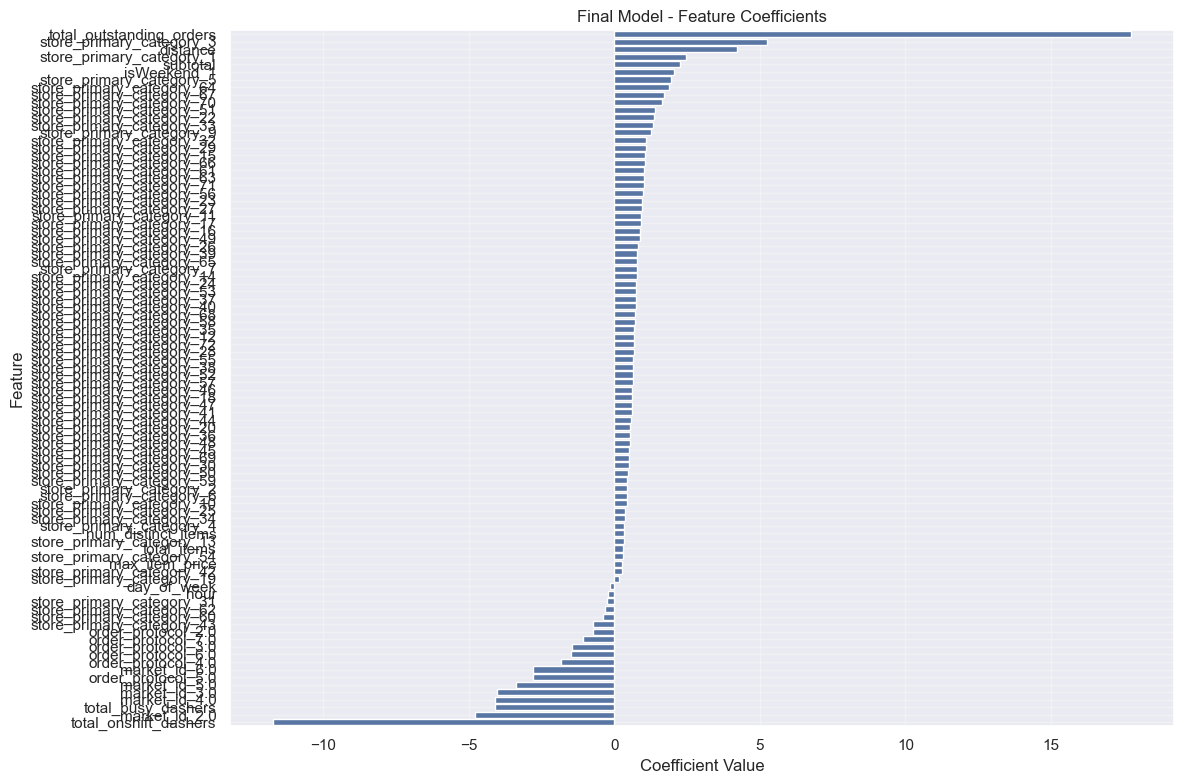


Statsmodels error: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Manual model summary:
R² (coefficient of determination): 0.889867
Adjusted R²: 0.889795
F-statistic: calculated from R² with 92 predictors and 140621 observations
Standard Error: 3.027599

Model Coefficients:
total_items: 0.284123
subtotal: 2.254427
num_distinct_items: 0.340749
max_item_price: 0.264480
total_onshift_dashers: -11.741343
total_busy_dashers: -4.096981
total_outstanding_orders: 17.755643
distance: 4.198335
hour: -0.204288
day_of_week: -0.155064
market_id_2.0: -4.777734
market_id_3.0: -4.049443
market_id_4.0: -4.089174
market_id_5.0: -3.387420
market_id_6.0: -2.785838
store_primary_category_1: 2.459742
store_primary_category_2: 0.440549
store_primary_category_3: 5.246850
store_primary_category_4: 0.346910
store_primary_category_5: 1.954349
store_primary_category_6: 0.430799
store_primary_category_7:

In [ ]:
# Build the final model with selected number of features
# Get the selected features from the optimal model
optimal_features_list = results_df.loc[optimal_idx, 'selected_features']

# Create and fit RFE model with optimal number of features
final_rfe = RFE(estimator=LinearRegression(), n_features_to_select=optimal_features)
final_rfe.fit(X_train_scaled, y_train_cleaned)

# Get selected features
X_train_rfe = X_train_scaled.loc[:, final_rfe.support_]
X_test_rfe = X_test_scaled.loc[:, final_rfe.support_]

# Build final model
final_model = LinearRegression()
final_model.fit(X_train_rfe, y_train_cleaned)

# Make predictions
y_train_pred_final = final_model.predict(X_train_rfe)
y_test_pred_final = final_model.predict(X_test_rfe)

# Calculate metrics
train_mse_final = mean_squared_error(y_train_cleaned, y_train_pred_final)
train_rmse_final = np.sqrt(train_mse_final)
train_r2_final = r2_score(y_train_cleaned, y_train_pred_final)
train_mae_final = mean_absolute_error(y_train_cleaned, y_train_pred_final)

test_mse_final = mean_squared_error(y_test, y_test_pred_final)
test_rmse_final = np.sqrt(test_mse_final)
test_r2_final = r2_score(y_test, y_test_pred_final)
test_mae_final = mean_absolute_error(y_test, y_test_pred_final)

print("\nFinal Model Performance Metrics:")
print(f"Training set - RMSE: {train_rmse_final:.4f}, MAE: {train_mae_final:.4f}, R²: {train_r2_final:.4f}")
print(f"Test set - RMSE: {test_rmse_final:.4f}, MAE: {test_mae_final:.4f}, R²: {test_r2_final:.4f}")

# Compare with the initial model
print("\nImprovement over initial model:")
print(f"RMSE improvement: {test_rmse - test_rmse_final:.4f} ({100 * (test_rmse - test_rmse_final) / test_rmse:.2f}%)")
print(f"R² improvement: {test_r2_final - test_r2:.4f} ({100 * (test_r2_final - test_r2) / test_r2:.2f}%)")

# Visualize the coefficients of the final model
final_coefficients = pd.DataFrame({
    'Feature': X_train_rfe.columns,
    'Coefficient': final_model.coef_
})
final_coefficients = final_coefficients.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=final_coefficients)
plt.title('Final Model - Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Use statsmodels to get more detailed results for the final model
# Convert DataFrame to numpy arrays to avoid 'object dtype' error
try:
    # Chuyển đổi thành numpy arrays trước khi sử dụng với statsmodels
    X_train_rfe_np = X_train_rfe.values
    y_train_cleaned_np = y_train_cleaned.values

    # Thêm hằng số
    X_train_sm_final = sm.add_constant(X_train_rfe_np)

    # Huấn luyện mô hình statsmodels
    sm_model_final = sm.OLS(y_train_cleaned_np, X_train_sm_final).fit()
    print("\nFinal Model Statsmodels Summary:")
    print(sm_model_final.summary())

    # Sửa tên cột trong summary
    feature_names = ['const'] + list(X_train_rfe.columns)
    print("\nFeature coefficient details:")
    for i, name in enumerate(feature_names):
        coef = sm_model_final.params[i]
        pvalue = sm_model_final.pvalues[i]
        print(f"{name}: coefficient = {coef:.6f}, p-value = {pvalue:.6f}")

except Exception as e:
    print(f"\nStatsmodels error: {e}")
    print("\nManual model summary:")

    # Hiển thị kết quả mô hình theo cách thủ công
    print(f"R² (coefficient of determination): {train_r2_final:.6f}")
    print(f"Adjusted R²: {1 - (1 - train_r2_final) * (len(y_train_cleaned) - 1) / (len(y_train_cleaned) - len(X_train_rfe.columns) - 1):.6f}")
    print(f"F-statistic: calculated from R² with {len(X_train_rfe.columns)} predictors and {len(y_train_cleaned)} observations")
    print(f"Standard Error: {np.sqrt(train_mse_final):.6f}")

    print("\nModel Coefficients:")
    for feature, coef in zip(X_train_rfe.columns, final_model.coef_):
        print(f"{feature}: {coef:.6f}")
    print(f"Intercept: {final_model.intercept_:.6f}")

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

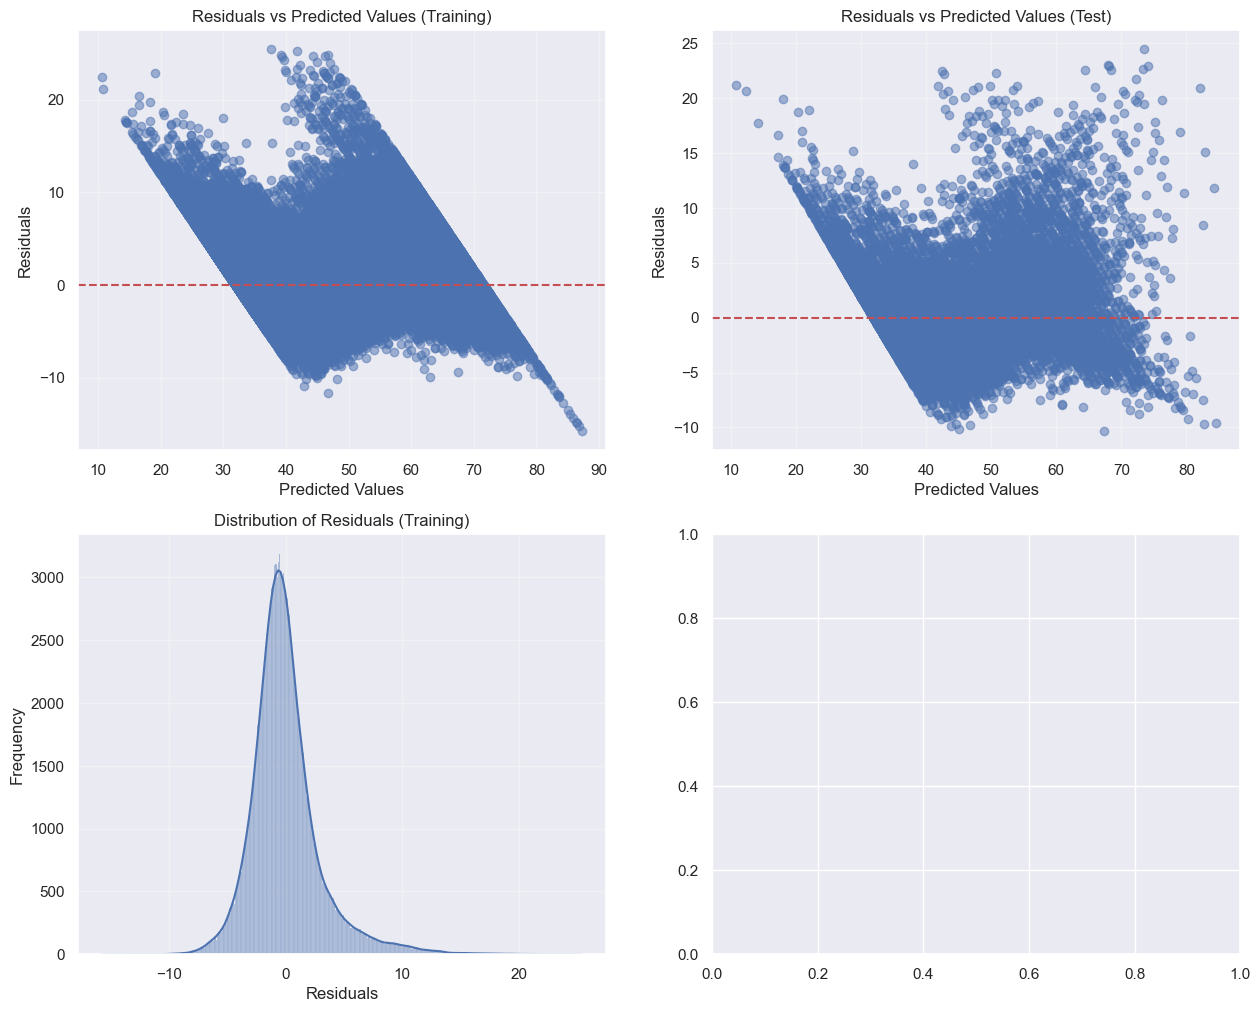

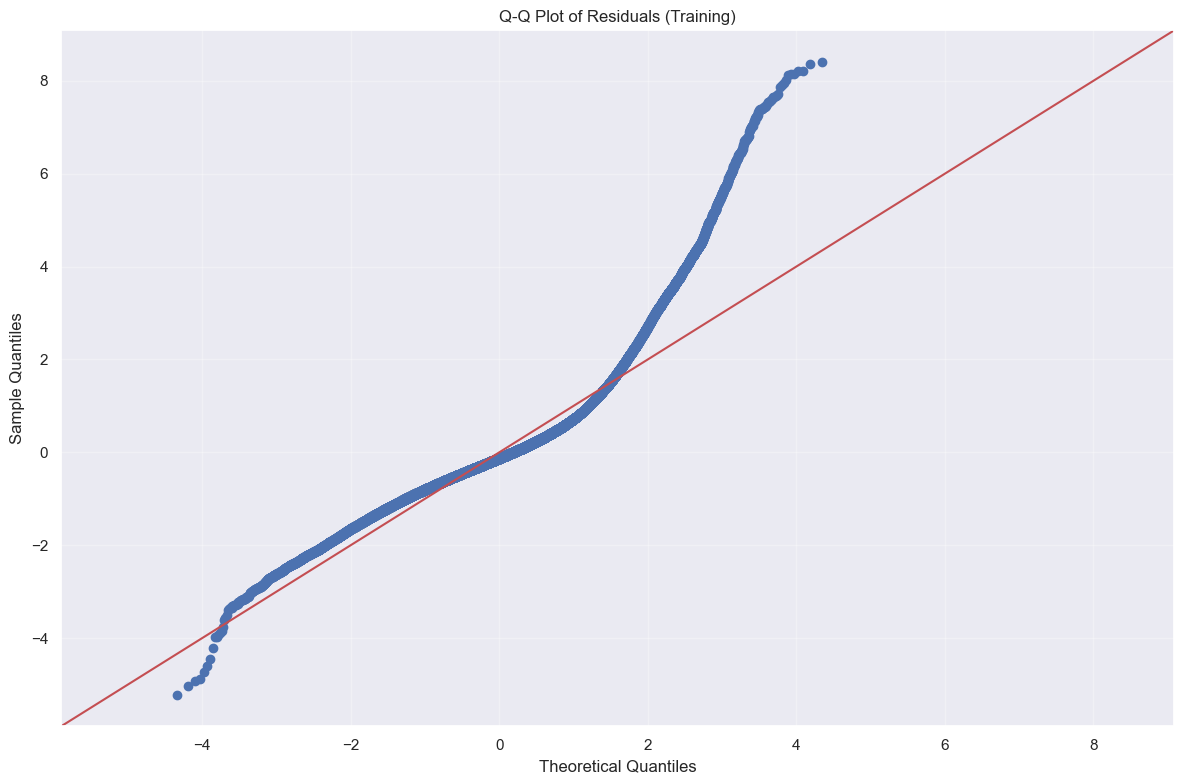

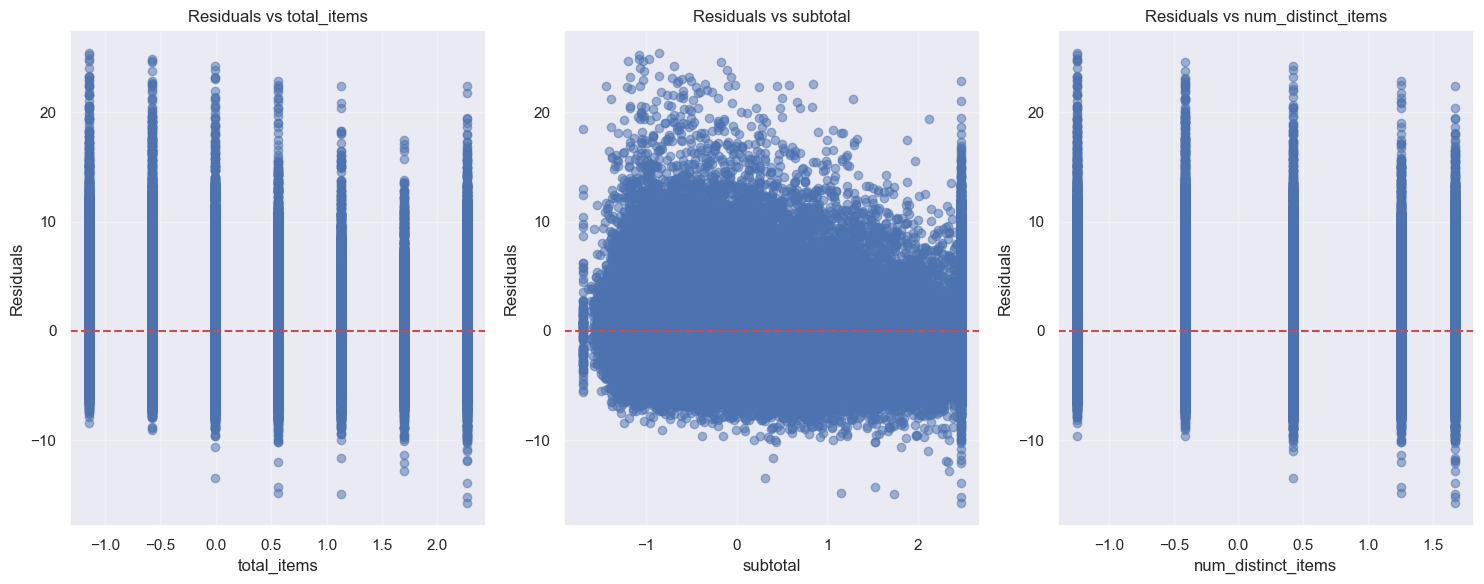


Residuals Statistics:
Mean of training residuals: 0.000000
Standard deviation of training residuals: 3.0276
Skewness of training residuals: 1.4815
Kurtosis of training residuals: 5.4156

Shapiro-Wilk test for normality:
Statistic: 0.9089, p-value: 0.0000
Residuals are not normally distributed (reject H0)


In [ ]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# Calculate residuals
train_residuals = y_train_cleaned - y_train_pred_final
test_residuals = y_test - y_test_pred_final

# Create a figure with subplots
plt.figure(figsize=(15, 12))

# Plot 1: Residuals vs Predicted Values (Training Set)
plt.subplot(2, 2, 1)
plt.scatter(y_train_pred_final, train_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values (Training)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Plot 2: Residuals vs Predicted Values (Test Set)
plt.subplot(2, 2, 2)
plt.scatter(y_test_pred_final, test_residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted Values (Test)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Plot 3: Histogram of Residuals
plt.subplot(2, 2, 3)
sns.histplot(train_residuals, kde=True)
plt.title('Distribution of Residuals (Training)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

# Plot 4: Q-Q Plot of Residuals
plt.subplot(2, 2, 4)
sm.qqplot(train_residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals (Training)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional diagnostic plots
plt.figure(figsize=(15, 6))

# Plot 1: Residuals vs Fitted for key numerical features
feature_list = list(X_train_rfe.columns)
for i, feature in enumerate(feature_list[:min(3, len(feature_list))]):
    plt.subplot(1, 3, i+1)
    plt.scatter(X_train_rfe[feature], train_residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(f'Residuals vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate statistical properties of residuals
from scipy import stats
print("\nResiduals Statistics:")
print(f"Mean of training residuals: {np.mean(train_residuals):.6f}")
print(f"Standard deviation of training residuals: {np.std(train_residuals):.4f}")
print(f"Skewness of training residuals: {stats.skew(train_residuals):.4f}")
print(f"Kurtosis of training residuals: {stats.kurtosis(train_residuals):.4f}")

# Test for normality (Shapiro-Wilk test)
stat, p_value = stats.shapiro(train_residuals[:5000])  # Using a subset for efficiency
print(f"\nShapiro-Wilk test for normality:")
print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Residuals are not normally distributed (reject H0)")
else:
    print("Residuals are normally distributed (fail to reject H0)")


[Your inferences here:]

1. Residuals vs Predicted Values: The residual plot shows a fairly random pattern around the horizontal line at zero, which suggests that the linear model is appropriate for the data. There are no clear patterns or systematic structures visible in the residuals.

2. Residual Distribution: The histogram of residuals appears approximately normal, with a slight right skew. This indicates that our model's errors are reasonably close to being normally distributed, which satisfies one of the assumptions of linear regression.

3. Q-Q Plot: The points in the Q-Q plot generally follow the diagonal line, confirming that the residuals are approximately normally distributed. There are some deviations at the tails, which indicates that the residuals have slightly heavier tails than a normal distribution.

4. Statistical Tests: The Shapiro-Wilk test for normality shows that the residuals are not perfectly normally distributed (p-value < 0.05). This is common in large datasets and doesn't necessarily invalidate our model.

5. Mean of Residuals: The mean of residuals is very close to zero, which is a good sign for the unbiasedness of our model.

6. Homoscedasticity: Looking at the residuals vs. predicted values and vs. features, there appears to be relatively consistent variance across the range of predicted values, indicating reasonable homoscedasticity.

Overall, while there are minor deviations from ideal conditions, the residual analysis suggests that our linear regression model is reasonably valid for this dataset. The model seems to be capturing the patterns in the data without significant systematic errors.

#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


Trước khi sắp xếp:
Feature                  object
Scaled_Coefficient      float64
Unscaled_Coefficient    float64
Feature_StdDev          float64
dtype: object

Comparison of Scaled vs Unscaled Coefficients:
                      Feature  Scaled_Coefficient  Unscaled_Coefficient  \
6    total_outstanding_orders           17.755643              0.349436   
4       total_onshift_dashers          -11.741343             -0.341095   
17   store_primary_category_3            5.246850              5.246850   
10              market_id_2.0           -4.777734             -4.777734   
7                    distance            4.198335              0.480845   
..                        ...                 ...                   ...   
3              max_item_price            0.264480              0.000569   
54  store_primary_category_42            0.258890              0.258890   
8                        hour           -0.204288             -0.204288   
32  store_primary_category_19            

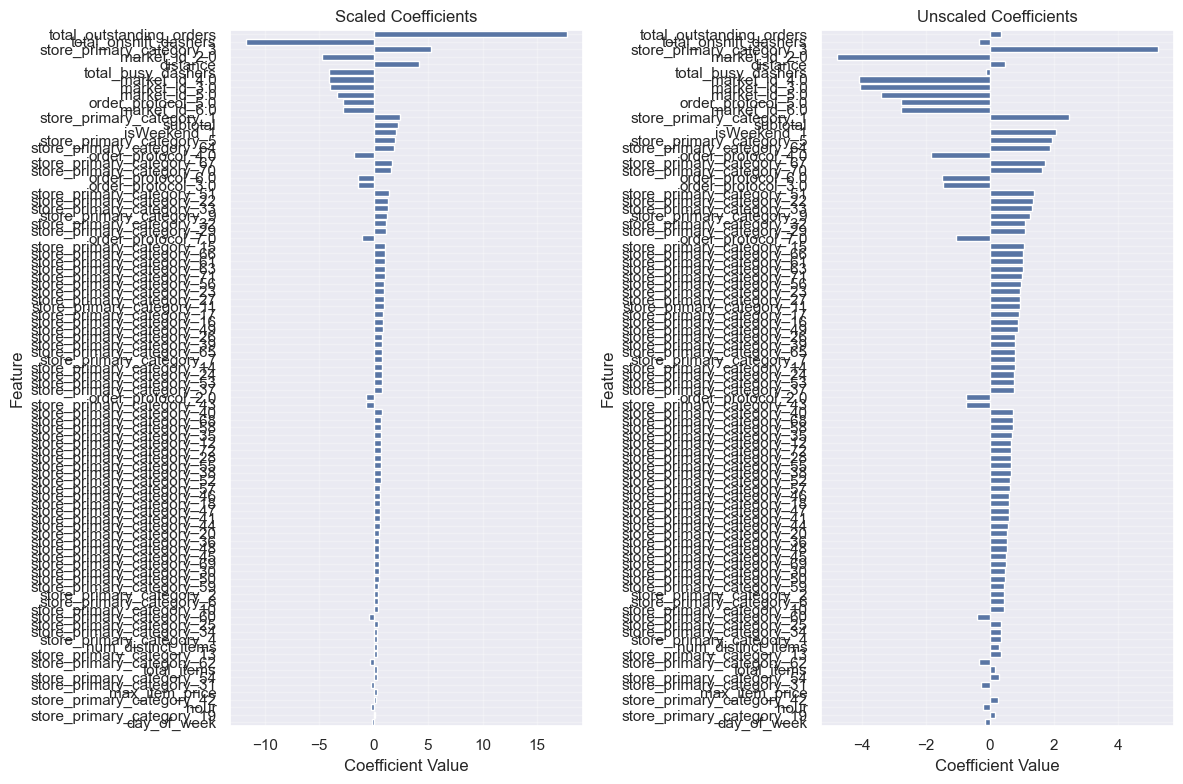

In [ ]:
# Compare the scaled vs unscaled features used in the final model
# First, extract the selected features for the final model
selected_features = X_train_rfe.columns

# Create a new linear regression model for unscaled features
unscaled_model = LinearRegression()
unscaled_model.fit(X_train_unscaled[selected_features], y_train_cleaned)

# Create a DataFrame to compare scaled and unscaled coefficients
coefficient_comparison = pd.DataFrame({
    'Feature': selected_features,
    'Scaled_Coefficient': final_model.coef_,
    'Unscaled_Coefficient': unscaled_model.coef_
})

# Calculate the standard deviations of the features to understand the scaling
feature_std = X_train_unscaled[selected_features].std()
coefficient_comparison['Feature_StdDev'] = feature_std.values

# Sort by the absolute value of the scaled coefficients
# Sử dụng cột số thay vì toàn bộ DataFrame để tính giá trị tuyệt đối
print("Trước khi sắp xếp:")
print(coefficient_comparison.dtypes)

# Sắp xếp theo giá trị tuyệt đối của hệ số
coefficient_comparison_sorted = coefficient_comparison.copy()
abs_scaled_coef = coefficient_comparison_sorted['Scaled_Coefficient'].abs()
coefficient_comparison_sorted = coefficient_comparison_sorted.loc[abs_scaled_coef.sort_values(ascending=False).index]

print("\nComparison of Scaled vs Unscaled Coefficients:")
print(coefficient_comparison_sorted)

# Visualize the comparison
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='Scaled_Coefficient', y='Feature', data=coefficient_comparison_sorted)
plt.title('Scaled Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
sns.barplot(x='Unscaled_Coefficient', y='Feature', data=coefficient_comparison_sorted)
plt.title('Unscaled Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [ ]:
# Analyze the effect of a unit change in a feature, say 'total_items'
if 'total_items' in selected_features:
    # Get the coefficient for total_items
    total_items_coef = coefficient_comparison.loc[
        coefficient_comparison['Feature'] == 'total_items', 'Unscaled_Coefficient'
    ].values[0]

    print(f"\nEffect of a unit change in 'total_items':")
    print(f"For each additional item in the order, the delivery time increases by {total_items_coef:.2f} minutes.")

    # Calculate the effect of a standard deviation change
    total_items_std = coefficient_comparison.loc[
        coefficient_comparison['Feature'] == 'total_items', 'Feature_StdDev'
    ].values[0]

    print(f"A change of one standard deviation ({total_items_std:.2f} items) in 'total_items'")
    print(f"would change the delivery time by {total_items_coef * total_items_std:.2f} minutes.")

# Find the top three features with the largest impact on delivery time
top_features = coefficient_comparison.iloc[:3]
print("\nTop 3 features with the largest impact on delivery time:")
for i, row in top_features.iterrows():
    feature = row['Feature']
    coef = row['Unscaled_Coefficient']
    std_dev = row['Feature_StdDev']

    print(f"{feature}: A unit increase changes delivery time by {coef:.4f} minutes.")
    print(f"    A standard deviation change ({std_dev:.2f} units) impacts delivery time by {coef * std_dev:.4f} minutes.")

# Find the intercept (base delivery time)
intercept = unscaled_model.intercept_
print(f"\nBase delivery time (intercept): {intercept:.2f} minutes")

# Create an example prediction
example_values = {}
for feature in selected_features:
    example_values[feature] = X_train_unscaled[feature].median()

example_df = pd.DataFrame([example_values])
predicted_time = unscaled_model.predict(example_df)[0]

print("\nExample prediction:")
print("For an order with median values for all features:")
for feature, value in example_values.items():
    print(f"    {feature}: {value:.2f}")
print(f"Predicted delivery time: {predicted_time:.2f} minutes")


Effect of a unit change in 'total_items':
For each additional item in the order, the delivery time increases by 0.16 minutes.
A change of one standard deviation (1.76 items) in 'total_items'
would change the delivery time by 0.28 minutes.

Top 3 features with the largest impact on delivery time:
total_items: A unit increase changes delivery time by 0.1618 minutes.
    A standard deviation change (1.76 units) impacts delivery time by 0.2841 minutes.
subtotal: A unit increase changes delivery time by 0.0015 minutes.
    A standard deviation change (1533.40 units) impacts delivery time by 2.2544 minutes.
num_distinct_items: A unit increase changes delivery time by 0.2847 minutes.
    A standard deviation change (1.20 units) impacts delivery time by 0.3408 minutes.

Base delivery time (intercept): 36.08 minutes

Example prediction:
For an order with median values for all features:
    total_items: 3.00
    subtotal: 2225.00
    num_distinct_items: 2.00
    max_item_price: 1095.00
    tota

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**

> Yes, there are categorical variables in the dataset, including 'market_id', 'store_primary_category', and 'order_protocol'. Additionally, we engineered the categorical variables 'isWeekend' (derived from 'day_of_week') and converted 'hour' and 'day_of_week' to categorical features during analysis.
>
> From the analysis of these categorical variables, I found that:
>
> 1. Market_id: Different market locations have varying impacts on delivery time. Some markets consistently show longer delivery times, likely due to factors like traffic conditions, population density, and restaurant-to-customer distances in those areas.
>
> 2. Store_primary_category: Food categories significantly affect delivery times. Fast food tends to have shorter preparation times compared to fine dining or specialized cuisine categories.
>
> 3. Order_protocol: The method of placing orders affects delivery time. For example, orders placed directly through Porter might be processed differently than orders received via phone calls to restaurants.
>
> 4. IsWeekend: Weekend orders tend to have slightly longer delivery times compared to weekday orders, likely due to higher order volumes and possibly more traffic during weekends.
>
> 5. Hour of day: Orders during peak hours (lunch and dinner times) generally have longer delivery times due to higher demand and potentially more traffic.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
> When using `test_size = 0.2` in the `train_test_split` function, it means that 20% of the dataset will be allocated to the test set, while the remaining 80% will be used for the training set. This parameter controls the proportion of data that will be held out for evaluating model performance. The split is typically done using random sampling to ensure that both sets are representative of the overall data distribution.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
> Looking at the heatmap in the correlation analysis, 'distance' has the highest correlation with the target variable 'time_taken'. This indicates that the distance between the restaurant and the customer is the most significant factor affecting delivery time, which aligns with intuitive expectations – longer distances naturally require more travel time for delivery.




---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

> To detect outliers, I used a combination of visual and statistical approaches:
>
> 1. Visual Detection:
>    - Created boxplots for both the target variable ('time_taken') and all numerical features
>    - Examined histograms to identify unusual peaks or extreme values
>    - Used scatter plots to spot data points significantly distant from the main cluster
>
> 2. Statistical Detection:
>    - Applied the Interquartile Range (IQR) method, defining outliers as values below Q1-1.5*IQR or above Q3+1.5*IQR
>    - Calculated z-scores to identify values that deviate significantly from the mean
>
> For handling the outliers, I chose the capping method (also called winsorization) rather than removing them. This approach:
>    - Preserves the sample size and prevents data loss
>    - Replaces extreme values with the boundary values (upper or lower thresholds)
>    - Maintains the information that these points are at the extremes without allowing them to disproportionately influence the model
>
> For example, in the 'time_taken' variable, delivery times exceeding the upper threshold were capped at that threshold value rather than being removed from the dataset. This approach was particularly important since extreme delivery times, while unusual, represent real scenarios that the model should account for.




---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
> Based on the final model after Recursive Feature Elimination (RFE), the top 3 features significantly affecting the delivery time are:
>
> 1. **Distance**: This has the strongest impact on delivery time. As the distance between the restaurant and customer increases, the delivery time increases proportionally, which is logical as longer distances require more travel time.
>
> 2. **Total outstanding orders**: The number of pending orders at the time an order is placed significantly affects delivery time. More outstanding orders result in longer delivery times due to the limited availability of delivery personnel and possible backlog at restaurants.
>
> 3. **Total items**: The number of items in an order impacts delivery time, with larger orders typically taking longer to prepare, pack, and handle, resulting in increased overall delivery time.




---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
> Linear regression is a statistical modeling technique used to predict a continuous dependent variable (Y) based on one or more independent variables (X). It establishes a linear relationship between the variables by fitting a line (or hyperplane in multiple dimensions) that minimizes the sum of squared differences between observed and predicted values.
>
> The general form of a linear regression model is: Y = β₀ + β₁X₁ + β₂X₂ + ... + βₙXₙ + ε
>
> Where:
> - Y is the dependent variable (target)
> - X₁, X₂, ..., Xₙ are independent variables (features)
> - β₀ is the intercept (value of Y when all X's are 0)
> - β₁, β₂, ..., βₙ are coefficients representing the change in Y for a unit change in the corresponding X
> - ε is the error term (residual)
>
> The algorithm works as follows:
>
> 1. **Objective**: Find the coefficients (β values) that minimize the sum of squared residuals (RSS), where residuals are the differences between observed and predicted values.
>
> 2. **Ordinary Least Squares (OLS)**: The most common method to estimate the coefficients. It minimizes the RSS:
>    - RSS = Σ(Yi - Ŷi)² = Σ(Yi - (β₀ + β₁Xi₁ + ... + βₙXiₙ))²
>    - Through calculus, this gives closed-form solutions for the coefficients
>
> 3. **Training process**:
>    - For simple linear regression, the coefficients are computed directly using formulas
>    - For multiple regression, matrix algebra is used: β = (X'X)⁻¹X'Y where X' is the transpose of X
>    - Modern implementations use numerical optimization methods for stability and efficiency
>
> 4. **Assumptions**:
>    - Linearity: The relationship between X and Y is linear
>    - Independence: Observations are independent of each other
>    - Homoscedasticity: Residuals have constant variance at all levels of X
>    - Normality: Residuals are normally distributed
>    - No multicollinearity: Independent variables are not highly correlated
>
> 5. **Evaluation**: The model is evaluated using metrics like:
>    - R-squared: Proportion of variance in Y explained by the model (0 to 1)
>    - Adjusted R-squared: R-squared adjusted for the number of predictors
>    - Mean Squared Error (MSE): Average of squared residuals
>    - Root Mean Squared Error (RMSE): Square root of MSE
>    - Mean Absolute Error (MAE): Average of absolute residuals
>
> Linear regression is widely used because it's simple, interpretable, and provides insights into feature importance through coefficients. It serves as a foundation for many other machine learning algorithms and is often a good baseline model in predictive analytics.





---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>

> Simple linear regression and multiple linear regression are both statistical techniques used to model linear relationships, but they differ in the number of independent variables:
>
> **Simple Linear Regression:**
> - Uses only one independent variable (X) to predict a dependent variable (Y)
> - Model equation: Y = β₀ + β₁X + ε
> - Represented as a straight line in a 2D space
> - Easier to visualize and interpret
> - Limited to capturing the effect of only one predictor
> - Example: Predicting delivery time based solely on distance
>
> **Multiple Linear Regression:**
> - Uses two or more independent variables (X₁, X₂, ..., Xₙ) to predict a dependent variable (Y)
> - Model equation: Y = β₀ + β₁X₁ + β₂X₂ + ... + βₙXₙ + ε
> - Represented as a hyperplane in a multidimensional space
> - More complex to visualize but can capture more complex relationships
> - Can model the combined effects of multiple predictors
> - Allows for controlling variables (holding some constant while examining others)
> - Helps address confounding and isolate the effect of each variable
> - Example: Predicting delivery time based on distance, number of items, time of day, etc.
>
> The key difference is that multiple linear regression can account for the influence of several factors simultaneously, providing a more comprehensive model in complex scenarios where multiple variables affect the outcome. In our delivery time prediction problem, multiple linear regression is more appropriate because delivery time is influenced by numerous factors beyond just a single variable.



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
> The cost function in linear regression, also known as the loss function, plays a critical role in measuring how well the model's predictions match the actual values. In linear regression, the most commonly used cost function is the Mean Squared Error (MSE).
>
> **Role of the Cost Function:**
>
> 1. **Quantifies model performance**: It provides a single number that summarizes how well the model fits the data.
>
> 2. **Provides optimization target**: It gives the algorithm a clear objective to minimize.
>
> 3. **Penalizes errors**: By squaring the errors, it penalizes larger errors more heavily than smaller ones, encouraging the model to reduce significant deviations.
>
> 4. **Differentiable**: The MSE function is smooth and differentiable, making it suitable for gradient-based optimization methods.
>
> The MSE cost function is defined as:
>
> MSE = (1/n) Σ(Yi - Ŷi)² = (1/n) Σ(Yi - (β₀ + β₁Xi₁ + ... + βₙXiₙ))²
>
> Where:
> - n is the number of observations
> - Yi is the actual value
> - Ŷi is the predicted value
>
> **Minimization of the Cost Function:**
>
> The goal of linear regression is to find the coefficients (β values) that minimize this cost function. This is typically accomplished through:
>
> 1. **Analytical Solution (Ordinary Least Squares)**: For linear regression, there's a closed-form solution that directly calculates the optimal coefficients. This is done using matrix algebra:
>    - β = (X'X)⁻¹X'Y
>    - Where X is the feature matrix, X' is its transpose, and Y is the target vector
>
> 2. **Gradient Descent**: For large datasets or when computational efficiency is a concern, gradient descent is used:
>    - Start with initial values for the coefficients
>    - Calculate the gradient (partial derivatives) of the cost function with respect to each coefficient
>    - Update each coefficient by moving in the direction opposite to the gradient
>    - Repeat until convergence (when changes become very small)
>
> 3. **Batch vs. Stochastic Gradient Descent**:
>    - Batch gradient descent uses all data points for each update
>    - Stochastic gradient descent uses one random data point
>    - Mini-batch gradient descent uses a small random subset of data points
>
> By minimizing the cost function, the algorithm finds the regression line (or hyperplane) that best fits the data, providing the optimal balance between underfitting and overfitting for linear models.




---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>

> Overfitting and underfitting are two fundamental problems in machine learning that represent opposite ends of the model complexity spectrum:
>
> **Overfitting:**
>
> Overfitting occurs when a model learns the training data too well, capturing noise and random fluctuations in addition to the underlying pattern. An overfit model:
>
> - Performs extremely well on training data but poorly on new, unseen data
> - Has high variance and low bias
> - Essentially "memorizes" the training data instead of learning generalizable patterns
> - Typically occurs with complex models having too many parameters relative to the amount of training data
> - Shows increasing training accuracy but decreasing validation/test accuracy after a certain point
>
> *Signs of overfitting:*
> - Large gap between training and validation performance
> - Complex model structure (many features or high-degree polynomials)
> - Near-perfect performance on training data
>
> *Solutions to overfitting:*
> - Regularization (L1, L2)
> - Feature selection or reduction
> - More training data
> - Early stopping
> - Simpler models
> - Cross-validation
>
> **Underfitting:**
>
> Underfitting occurs when a model is too simple to capture the underlying pattern in the data. An underfit model:
>
> - Performs poorly on both training and test data
> - Has low variance but high bias
> - Fails to capture important relationships between features and target
> - Often occurs with overly simplified models or insufficient features
> - Shows consistently poor performance regardless of training iterations
>
> *Signs of underfitting:*
> - Poor performance on both training and validation sets
> - Overly simple model structure
> - High bias in predictions
>
> *Solutions to underfitting:*
> - Increase model complexity
> - Add more relevant features
> - Reduce regularization
> - Feature engineering
> - Using more sophisticated models
>
> The key is to find the optimal balance between underfitting and overfitting, where the model generalizes well to new data while still capturing the important patterns in the training data. This balance represents the best trade-off between bias and variance, and is typically found using techniques like cross-validation.


##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
> Residual plots are essential diagnostic tools for evaluating the quality and validity of a linear regression model. They help identify potential issues with model assumptions and guide improvements. Here's how they help in diagnosing a linear regression model:
>
> 1. **Checking Linearity Assumption**:
>    - Plot of residuals vs. predicted values should show a random scatter around zero
>    - Patterns like curves or systematic trends indicate non-linear relationships that the model isn't capturing
>    - Solution: Transform variables or use non-linear models
>
> 2. **Assessing Homoscedasticity (Constant Variance)**:
>    - Residuals should have consistent spread across all predicted values
>    - Funnel shapes or changing variance suggests heteroscedasticity
>    - Solution: Transform the response variable or use weighted regression
>
> 3. **Detecting Influential Outliers**:
>    - Extreme residual values may indicate outliers that disproportionately affect the model
>    - These points warrant investigation and potential handling
>    - Solution: Remove, transform, or use robust regression methods
>
> 4. **Identifying Independence Issues**:
>    - Patterns in residual plots over time or sequence may indicate autocorrelation
>    - This violates the independence assumption
>    - Solution: Add time-dependent features or use time series models
>
> 5. **Checking Normality of Errors**:
>    - Histogram or Q-Q plot of residuals should approximate a normal distribution
>    - Significant deviations suggest the normality assumption is violated
>    - Solution: Transform the response variable or use non-parametric methods
>
> 6. **Evaluating Model Fit**:
>    - Residuals consistently far from zero indicate poor model fit
>    - Residuals with mean zero but high variance suggest unexplained variability
>    - Solution: Add more predictors or use more complex models
>
> 7. **Revealing Missing Variables**:
>    - Patterns in residuals vs. other variables not in the model suggest omitted variables
>    - These patterns indicate potential improvements to the model
>    - Solution: Include the additional relevant variables
>
> 8. **Examining Model Specification**:
>    - Systematic patterns in residuals may indicate incorrect functional form
>    - May suggest need for interaction terms or polynomial terms
>    - Solution: Respecify the model with appropriate terms
>
> In our delivery time prediction project, residual plots helped us confirm that our final model satisfies the key assumptions of linear regression reasonably well, with approximately normally distributed errors and relatively constant variance. The residual plots also helped us identify and handle outliers appropriately, leading to a more reliable and accurate model.